In [ ]:
!pip install gymnasium
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
API_PIN = "f1289fbe9fb814423f3d4f7509c7f3662b2abd0a"

In [ ]:
!wandb login

wandb: Currently logged in as: crna. Use `wandb login --relogin` to force relogin


Pendulum Documentation: [Link](https://www.gymlibrary.dev/environments/classic_control/pendulum/)

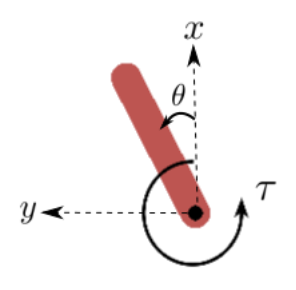

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
import gymnasium as gym
import torch.autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import sys
import cv2
import wandb
import random

# For Replay Buffer
import random
from collections import deque

## New Safe Set Formulation

In [ ]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

class DDPGagent:

    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000,angle_threshold = 20,angle_threshold_epsilon=5):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        self.env = env
        self.angle_threshold = angle_threshold
        self.angle_threshold_epsilon = angle_threshold_epsilon

        # Env Config
        self.Tm = 2
        self.m = 1
        self.l = 1
        self.g = 9.81

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        assert self.env.action_space.high[0]==2

        return self.env.action_space.high[0]*action # Coz the output of the policy network is between -1,1 (added on 4/10/2023)

    def is_safe_state(self,state):
        '''
        The arguments must be in radians
        '''
        theta0 = self.angle_threshold*np.pi/180
        theta = np.arctan2(state[1],state[0])
        omega = state[2]

        if abs(theta)>theta0:
            return False
        else:
            if omega - f1(theta,theta0)<0 and omega-f2(theta,theta0)>0:
                return True
            else:
                return False

    def is_safe_state2(self,state):
        '''
        This marks the boundary of the marginally safe state space
        '''

        Tm = self.Tm
        m = self.m
        l = self.l
        g = self.g

        theta0 = self.angle_threshold*np.pi/180
        theta = np.arctan2(state[1],state[0])
        omega = state[2]

        if abs(theta)>theta0:
            return False

        if omega>=0:
            h = -Tm*(theta0-theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))
        else:
            h = -Tm*(theta0+theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))

        if h<=0:
            return True
        else:
            return False

    def is_marginally_safe(self,state):
        '''
        This is for the states between the inner and outer region representing the buffer region of marginally safe region
        '''
        if self.is_safe_state_shrunk(state)==False and self.is_safe_state2(state)==True:
            return True
        else:
            return False

    def is_safe_state_shrunk(self,state):
        '''
        This marks the boundary of the inner shrunk safe state space
        '''
        Tm = self.Tm
        m = self.m
        l = self.l
        g = self.g

        theta0 = self.angle_threshold_epsilon*np.pi/180
        theta = np.arctan2(state[1],state[0])
        omega = state[2]

        if abs(theta)>theta0:
            return False

        if omega>=0:
            h = -Tm*(theta0-theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))
        else:
            h = -Tm*(theta0+theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))

        if h<=0:
            return True
        else:
            return False


    def is_safe(self,state,action):

        assert len(state)==3

        angle = np.arctan2(state[1],state[0])*180/np.pi
        angle_threshold = self.angle_threshold
        safety = 1

        # if abs(angle)<angle_threshold:
        if abs(angle)<self.angle_threshold_epsilon:
            if action*state[2]>0:
                safety = 0

        else:
            if action*angle>=0: #if both action and the angle have same sign
                safety = 0
        # if abs(angle)>angle_threshold:
        #     if action*angle>0: #if both action and the angle have same sign
        #         safety = 0


        return safety

    def get_safe_action(self,state,action,epsilon=0.1):

        # assert len(state)==3

        # safety = self.is_safe(state,action)
        # if safety:
        #     return action
        # else:

        angle = np.arctan2(state[1],state[0])*180/np.pi
        action_range = self.env.action_space.high[0]

        # if abs(state[2])>0:
        #     action = -action_range
        # else:
        #     action = action_range

        if abs(angle)<self.angle_threshold_epsilon:
            if state[2]>0:
                action = -action_range
            elif state[2]<0:
                action = action_range
            else:
                action = 0

        else:
            if angle>0:
                action = -action_range
            else:
                action = action_range

        return np.array([action])

            # if action>0:
            #     return np.array([-self.env.action_space.high[0]])

            # elif action<0:
            #     return np.array([self.env.action_space.high[0]])

            # elif action==0:
            #     if angle>0:
            #         return np.array([-self.env.action_space.high[0]])
            #     else:
            #         return np.array([self.env.action_space.high[0]])


            # resolution = 100
            # zero_tol = 0.01
            # action_range = self.env.action_space.high[0]

            # probab = np.random.uniform(0,1)
            # if probab<epsilon:
            #     if action[0]<=0:
            #         action = np.random.uniform(zero_tol,action_range)

            #     else:
            #         action = np.random.uniform(-zero_tol,-action_range)

            #     return np.array([action])


            # if action[0]<=0:
            #     safe_action_space = torch.linspace(zero_tol,action_range,resolution).unsqueeze(1)
            #     #We need the safe action set in the direction opposite to angle deviation

            # else:
            #     safe_action_space = torch.linspace(-zero_tol,-action_range,resolution).unsqueeze(1)



            # state_tensor = Variable(torch.from_numpy(state).float().unsqueeze(0))
            # state_concat = torch.cat([state_tensor] * resolution, dim=0) #Stacked Tensor with same state value to pass into critic

            # Qvals = self.critic.forward(state_concat, safe_action_space)
            # action_index = torch.argmax(Qvals)

            # #action is a (1,1) shaped ndarray below
            # action = safe_action_space[action_index].detach().numpy() #finding the action with highest Q value
            # return action

    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Critic loss
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()

        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        # Update the noise state according to the Ornstein-Uhlenbeck process
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

def get_angle(state):
    return (np.arctan2(state[1],state[0])*180/np.pi)


def run_algo(config_dict):
    batch_size = config_dict['batch_size']
    hidden_size = config_dict['hidden_size']
    num_episodes = config_dict['num_episodes']
    num_episodes_test = config_dict['num_episodes_test']
    angle_threshold = config_dict['angle_threshold']
    angle_threshold_start = config_dict['angle_threshold_start']
    velocity_threshold_start = config_dict['velocity_threshold_start']
    ensure_safe_set = config_dict['ensure_safe_set'] # Safe, Partially Safe, No Safe Action Set
    safety_ratio = config_dict['safety_ratio']
    num_time_steps = config_dict['num_time_steps']
    safe_action_epsilon = config_dict['safe_action_epsilon']
    angle_threshold_epsilon = config_dict['angle_threshold_epsilon']

    assert ensure_safe_set == 'safe' or ensure_safe_set == 'partially_safe' or ensure_safe_set =='no safe set'

    if config_dict['wandb_log']:
        wandb.init(
            # set the wandb project where this run will be logged
            project="ddpg",

            # track hyperparameters and run metadata
            config=config_dict
        )

    env = gym.make("Pendulum-v1",render_mode = 'rgb_array')
    agent = DDPGagent(env,hidden_size=hidden_size,angle_threshold = angle_threshold,angle_threshold_epsilon=angle_threshold_epsilon)
    noise = OUNoise(env.action_space)

    rewards = []

    starting_angles = [] #The angle with which the episode starts
    starting_velocities = [] #The velocity with which the episode starts
    average_action_list = [] #The average torque in an episode
    average_angle_list = []  #The average angle in an episode
    average_reward_list = [] #The average reward in an episode
    steps_list = []          #Stores the number of steps in each episode
    average_safe_action_list = [] #Stores the percentage of safe action generated before the safety layer intervention
    safe_state_percent_list = []
    marginally_safe_state_percent_list = []
    action_trajectories = {} # Stores the action trajectory for each episode
    safe_action_flag_trajectories = {}

    angle_trajectories = {}  # Stores the angle trajectory for each episode
    action_trajectories_after_safety_layer = {} # Stores the velocity trajectory for each episode
    velocity_trajectories = {}
    # safety_violations_list = []

    episode = 0
    while episode < num_episodes:


        state,_ = env.reset()

        if agent.is_safe_state2(state)==False:
            # Ensuring that the episode starts in a safe state
            continue
        else:
            action_trajectory = []
            safe_action_flag_trajectory = []

            angle_trajectory = []
            velocity_trajectory = []
            action_trajectory_after_safety_layer = []

            episode += 1
            starting_angle = (np.arctan2(state[1],state[0])*180/np.pi)
            starting_velocity = state[2]


            starting_angles.append(starting_angle) # Data Collection
            starting_velocities.append(starting_velocity)

            assert abs(starting_angle)<angle_threshold

            noise.reset()
            episode_reward = 0
            within_threshold_count = 0
            action_within_threshold = 0
            safe_action_count_within_threshold = 0
            angle_sum = 0
            action_sum = 0
            step = 0
            num_safe_actions = 0
            num_safe_actions_old = 0
            num_safe_state = 0
            num_marginally_safe_state = 0

            # safety_violations = 0

            while True:
                step+=1
                angle = np.arctan2(state[1],state[0])*180/np.pi
                angle_sum += abs(angle)

                action = agent.get_action(state) # This is scalar
                action = noise.get_action(action, step) # This is a numpy array

                action_trajectory.append(action[0])
                angle_trajectory.append(angle)
                velocity_trajectory.append(state[2])

                # if agent.is_safe(state,action[0])==1:
                #     num_safe_actions+=1

                if action*angle<=0: #Must be less than or equal to i.e complement of action*angle>0 for unsafe
                    num_safe_actions_old+=1

                if agent.is_safe_state2(state):
                    pass
                else:
                    print('Not Safe State',step)

                if ensure_safe_set=='safe':
                    if agent.is_safe_state_shrunk(state):
                        pass
                    else:
                        action = agent.get_safe_action(state,action,safe_action_epsilon)
                    # assert agent.is_safe(state,action)==1

                elif ensure_safe_set == 'partially_safe':
                    if np.random.uniform(0,1) < safety_ratio:
                        if agent.is_safe_state2(state):
                            pass
                        else:
                            action = agent.get_safe_action(state,action,safe_action_epsilon)



                ##### logging variables #######
                if agent.is_safe(state,action[0])==1:
                    num_safe_actions+=1
                safe_action_flag_trajectory.append(agent.is_safe(state,action[0]))

                action_trajectory_after_safety_layer.append(action[0])

                action_sum += abs(action[0])

                if agent.is_safe_state_shrunk(state):
                    num_safe_state+=1
                if agent.is_marginally_safe(state):
                    num_marginally_safe_state+=1


                ###############################
                new_state, reward, done, truncated,_ = env.step(action)

                if abs(get_angle(new_state))>angle_threshold:
                    # safety_violations+=1
                    done = True

                agent.memory.push(state, action, reward, new_state, done)

                if len(agent.memory) > batch_size:
                    agent.update(batch_size)

                state = new_state
                episode_reward += reward

                if done or truncated:


                    # Logging
                    average_action = action_sum/step
                    average_angle = angle_sum/step
                    average_reward = episode_reward/step
                    average_num_safe_action = num_safe_actions/step
                    average_num_safe_action_old = num_safe_actions_old/step
                    average_num_safe_state = num_safe_state/step
                    average_num_marginally_safe_state = num_marginally_safe_state/step

                    steps_list.append(step)
                    average_angle_list.append(average_angle)
                    average_action_list.append(average_action)
                    average_reward_list.append(average_reward)
                    average_safe_action_list.append(average_num_safe_action*100)
                    safe_state_percent_list.append(average_num_safe_state*100)
                    marginally_safe_state_percent_list.append(average_num_marginally_safe_state*100)
                    # safety_violations_list.append(safety_violations)

                    if config_dict['wandb_log']:

                        wandb.log({'Steps':step,
                                   'Percent Safe State':average_num_safe_state*100,
                                   'Percent Marginally Safe State':average_num_marginally_safe_state*100,
                                   'Average Reward':average_reward,
                                   'Average Angle':average_angle,
                                   'Average Action (Torque)':average_action,
                                   'Starting Angle':starting_angle,
                                   'Starting Velocity':starting_velocity})
                                #    'Safety Violations':safety_violations})

                    print("Episode: {} | Steps: {} | Average Reward: {:.2f} | Average Angle: {:.2f} | Average Action (Torque): {:.2f} |  Starting Angle: {:.2f} "
                          "| Starting Velocity: {:.2f} | Percent Safe State: {:.2f} | Percent Marginally Safe State: {:.2f} ".format(episode,step,
                                                                                                                                    average_reward,
                                                                                                                                    average_angle,
                                                                                                                                    average_action,
                                                                                                                                    starting_angle,
                                                                                                                                    starting_velocity,
                                                                                                                                    average_num_safe_state*100,
                                                                                                                                    average_num_marginally_safe_state*100))

                    break

            action_trajectories[episode] = action_trajectory
            angle_trajectories[episode] = angle_trajectory
            velocity_trajectories[episode] = velocity_trajectory
            action_trajectories_after_safety_layer[episode] = action_trajectory_after_safety_layer
            safe_action_flag_trajectories[episode] = safe_action_flag_trajectory








    plt.plot(steps_list)
    # plt.plot(average_reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.show()

    info_train = {'starting_angles':starting_angles,
            'average_angle':average_angle_list,
            'average_action':average_action_list,
            'steps_list':steps_list,
            'average_rewards':average_reward_list,
            'percent_safe_action':average_num_safe_action*100,
            'safe_state_percent_list':safe_state_percent_list,
            'marginally_safe_state_percent_list':marginally_safe_state_percent_list,
            'action_trajectories':action_trajectories,
            'angle_trajectories':angle_trajectories,
            'velocity_trajectories':velocity_trajectories,
            'action_trajectories_after_safety_layer':action_trajectories_after_safety_layer,
            'safe_action_flag_trajectories':safe_action_flag_trajectories}


############################### TESTING PHASE #############################
    print("############### TESTING PHASE #############")
    rewards = []

    starting_angles = [] #The angle with which the episode starts
    starting_velocities = [] #The velocity with which the episode starts
    average_action_list = [] #The average torque in an episode
    average_angle_list = []  #The average angle in an episode
    average_reward_list = [] #The average reward in an episode
    steps_list = []          #Stores the number of steps in each episode
    average_safe_action_list = [] #Stores the percentage of safe action generated before the safety layer intervention
    safe_state_percent_list = []
    marginally_safe_state_percent_list = []
    action_trajectories = {} # Stores the action trajectory for each episode
    safe_action_flag_trajectories = {}

    angle_trajectories = {}  # Stores the angle trajectory for each episode
    action_trajectories_after_safety_layer = {} # Stores the velocity trajectory for each episode
    velocity_trajectories = {}
    # safety_violations_list = []

    episode = 0
    while episode < num_episodes_test:


        state,_ = env.reset()

        if agent.is_marginally_safe(state)==False:
            # Ensuring that the episode starts in a safe state
            continue
        else:
            action_trajectory = []
            safe_action_flag_trajectory = []

            angle_trajectory = []
            velocity_trajectory = []
            action_trajectory_after_safety_layer = []

            episode += 1
            starting_angle = (np.arctan2(state[1],state[0])*180/np.pi)
            starting_velocity = state[2]


            starting_angles.append(starting_angle) # Data Collection
            starting_velocities.append(starting_velocity)

            assert abs(starting_angle)<angle_threshold

            noise.reset()
            episode_reward = 0
            within_threshold_count = 0
            action_within_threshold = 0
            safe_action_count_within_threshold = 0
            angle_sum = 0
            action_sum = 0
            step = 0
            num_safe_actions = 0
            num_safe_actions_old = 0
            num_safe_state = 0
            num_marginally_safe_state = 0

            # safety_violations = 0

            while True:
                step+=1
                angle = np.arctan2(state[1],state[0])*180/np.pi
                angle_sum += abs(angle)

                action = agent.get_action(state) # This is scalar
                action = noise.get_action(action, step) # This is a numpy array

                action_trajectory.append(action[0])
                angle_trajectory.append(angle)
                velocity_trajectory.append(state[2])

                # if agent.is_safe(state,action[0])==1:
                #     num_safe_actions+=1

                if action*angle<=0: #Must be less than or equal to i.e complement of action*angle>0 for unsafe
                    num_safe_actions_old+=1

                if agent.is_safe_state2(state):
                    pass
                else:
                    print('Not Safe State',step)

                # if ensure_safe_set=='safe':
                #     if agent.is_safe_state_shrunk(state):
                #         pass
                #     else:
                #         action = agent.get_safe_action(state,action,safe_action_epsilon)
                #     # assert agent.is_safe(state,action)==1

                # elif ensure_safe_set == 'partially_safe':
                #     if np.random.uniform(0,1) < safety_ratio:
                #         if agent.is_safe_state2(state):
                #             pass
                #         else:
                #             action = agent.get_safe_action(state,action,safe_action_epsilon)



                ##### logging variables #######
                if agent.is_safe(state,action[0])==1:
                    num_safe_actions+=1
                safe_action_flag_trajectory.append(agent.is_safe(state,action[0]))

                action_trajectory_after_safety_layer.append(action[0])

                action_sum += abs(action[0])

                if agent.is_safe_state_shrunk(state):
                    num_safe_state+=1
                if agent.is_marginally_safe(state):
                    num_marginally_safe_state+=1


                ###############################
                new_state, reward, done, truncated,_ = env.step(action)

                if abs(get_angle(new_state))>angle_threshold:
                    # safety_violations+=1
                    done = True

                # # agent.memory.push(state, action, reward, new_state, done)

                # if len(agent.memory) > batch_size:
                #     agent.update(batch_size)

                state = new_state
                episode_reward += reward

                if done or truncated:


                    # Logging
                    average_action = action_sum/step
                    average_angle = angle_sum/step
                    average_reward = episode_reward/step
                    average_num_safe_action = num_safe_actions/step
                    average_num_safe_action_old = num_safe_actions_old/step
                    average_num_safe_state = num_safe_state/step
                    average_num_marginally_safe_state = num_marginally_safe_state/step

                    steps_list.append(step)
                    average_angle_list.append(average_angle)
                    average_action_list.append(average_action)
                    average_reward_list.append(average_reward)
                    average_safe_action_list.append(average_num_safe_action*100)
                    safe_state_percent_list.append(average_num_safe_state*100)
                    marginally_safe_state_percent_list.append(average_num_marginally_safe_state*100)
                    # safety_violations_list.append(safety_violations)

                    if config_dict['wandb_log']:

                        wandb.log({'Test/Steps':step,
                                   'Test/Percent Safe State':average_num_safe_state*100,
                                   'Test/Percent Marginally Safe State':average_num_marginally_safe_state*100,
                                   'Test/Average Reward':average_reward,
                                   'Test/Average Angle':average_angle,
                                   'Test/Average Action (Torque)':average_action,
                                   'Test/Starting Angle':starting_angle,
                                   'Test/Starting Velocity':starting_velocity})
                                #    'Safety Violations':safety_violations})

                    print("Episode: {} | Steps: {} | Average Reward: {:.2f} | Average Angle: {:.2f} | Average Action (Torque): {:.2f} |  Starting Angle: {:.2f} "
                          "| Starting Velocity: {:.2f} | Percent Safe State: {:.2f} | Percent Marginally Safe State: {:.2f} ".format(episode,step,
                                                                                                                                    average_reward,
                                                                                                                                    average_angle,
                                                                                                                                    average_action,
                                                                                                                                    starting_angle,
                                                                                                                                    starting_velocity,
                                                                                                                                    average_num_safe_state*100,
                                                                                                                                    average_num_marginally_safe_state*100))

                    break

            action_trajectories[episode] = action_trajectory
            angle_trajectories[episode] = angle_trajectory
            velocity_trajectories[episode] = velocity_trajectory
            action_trajectories_after_safety_layer[episode] = action_trajectory_after_safety_layer
            safe_action_flag_trajectories[episode] = safe_action_flag_trajectory








    plt.plot(steps_list)
    # plt.plot(average_reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.show()

    info_test = {'starting_angles':starting_angles,
            'average_angle':average_angle_list,
            'average_action':average_action_list,
            'steps_list':steps_list,
            'average_rewards':average_reward_list,
            'percent_safe_action':average_num_safe_action*100,
            'safe_state_percent_list':safe_state_percent_list,
            'marginally_safe_state_percent_list':marginally_safe_state_percent_list,
            'action_trajectories':action_trajectories,
            'angle_trajectories':angle_trajectories,
            'velocity_trajectories':velocity_trajectories,
            'action_trajectories_after_safety_layer':action_trajectories_after_safety_layer,
            'safe_action_flag_trajectories':safe_action_flag_trajectories}

####################$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$###################

    if config_dict['wandb_log']:
        wandb.finish()

    return agent, noise, env, info_train, info_test

Not Safe State 124
Not Safe State 125
Not Safe State 126
Not Safe State 127
Not Safe State 128
Not Safe State 129
Not Safe State 130
Not Safe State 131
Episode: 1 | Steps: 131 | Average Reward: -0.04 | Average Angle: 9.12 | Average Action (Torque): 1.11 |  Starting Angle: 12.78 | Starting Velocity: 0.23 | Percent Safe State: 57.25 | Percent Marginally Safe State: 36.64 


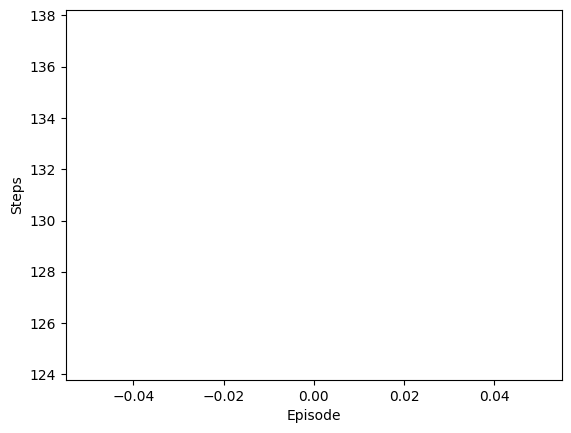

############### TESTING PHASE #############
Not Safe State 12
Not Safe State 13
Episode: 1 | Steps: 13 | Average Reward: -0.06 | Average Angle: 10.13 | Average Action (Torque): 0.20 |  Starting Angle: -10.91 | Starting Velocity: 0.73 | Percent Safe State: 53.85 | Percent Marginally Safe State: 30.77 


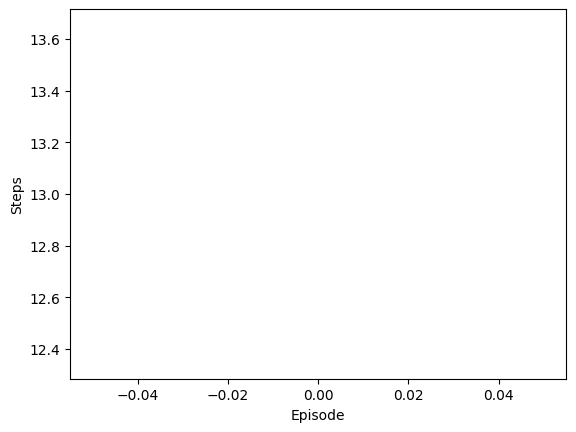

In [ ]:
for i in range(1):
    config_dict = {'batch_size':128,
                'hidden_size':256,
                'angle_threshold':20,
                'angle_threshold_start':15, #An episode starts only if the initial angle is within this.
                'velocity_threshold_start':0.6,
                'num_episodes':1,
                'num_episodes_test':1,
                'ensure_safe_set':'safe',
                'safety_ratio':0.7,
                'wandb_log':False,
                'num_time_steps':200,
                'safe_action_epsilon':0.1,
                'angle_threshold_epsilon':10}

    agent, noise, env, info_train,info_test = run_algo(config_dict)

In [ ]:
for i in range(1):
    config_dict = {'batch_size':128,
                'hidden_size':256,
                'angle_threshold':20,
                'angle_threshold_start':15, #An episode starts only if the initial angle is within this.
                'velocity_threshold_start':0.6,
                'num_episodes':100,
                'num_episodes_test':50,
                'ensure_safe_set':'safe',
                'safety_ratio':0.7,
                'wandb_log':False,
                'num_time_steps':200,
                'safe_action_epsilon':0.1,
                'angle_threshold_epsilon':10}

    agent, noise, env, info_train,info_test = run_algo(config_dict)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 1162, in init
    wi.setup(kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 306, in setup
    wandb_login._login(
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_login.py", line 298, in _login
    wlogin.prompt_api_key()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_login.py", line 221, in prompt_api_key
    key, status = self._prompt_api_key()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_login.py", line 201, in _prompt_api_key
    key = apikey.prompt_api_key(
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/

Error: ignored

## Testing Phase

In [ ]:
#### Plotting Helper Functions

Tm = 2
theta0 = 20*np.pi/180
m = 1
l = 1
g = 9.81

def f1(theta,theta0):
    theta = np.array(theta)
    if (abs(theta)>theta0).any():
        raise ValueError('Theta Value is outside safe range')
    else:
        return np.sqrt((6/(m*l**2))*(Tm*(theta0-theta)+0.5*m*g*l*(np.cos(theta0)-np.cos(theta))))

def f2(theta,theta0):
    theta = np.array(theta)

    if (abs(theta)>theta0).any():
        raise ValueError('Theta Value is outside safe range')
    else:
        return -np.sqrt((6/(m*l**2))*(Tm*(theta0+theta)+0.5*m*g*l*(np.cos(theta0)-np.cos(theta))))


def plot_safe_set(theta0,ax,color):
    theta_axis = np.linspace(-theta0,theta0,1000)

    boundary_1 = f1(theta_axis,theta0)
    boundary_2 = f2(theta_axis,theta0)

    theta_axis = theta_axis*180/np.pi

    ax.grid(True)
    ax.plot(theta_axis,boundary_1,color=color)
    ax.plot(theta_axis,boundary_2,color=color)
    ax.plot([theta_axis[0],theta_axis[0]],[boundary_1[0],boundary_2[0]],color=color)
    ax.plot([theta_axis[-1],theta_axis[-1]],[boundary_1[-1],boundary_2[-1]],color=color)
    ax.set_xlim([-35,35])
    ax.set_ylim([-4,4])
    ax.set_ylabel(r'$\dot{\theta}$ (rad/s)')
    ax.set_xlabel(r'$\theta$ (in degrees)')
    ax.set_title(r'$\theta_{0}$ = ' + str(int(round(theta0*180/np.pi,0))))

    return ax

### Forced Disturbances

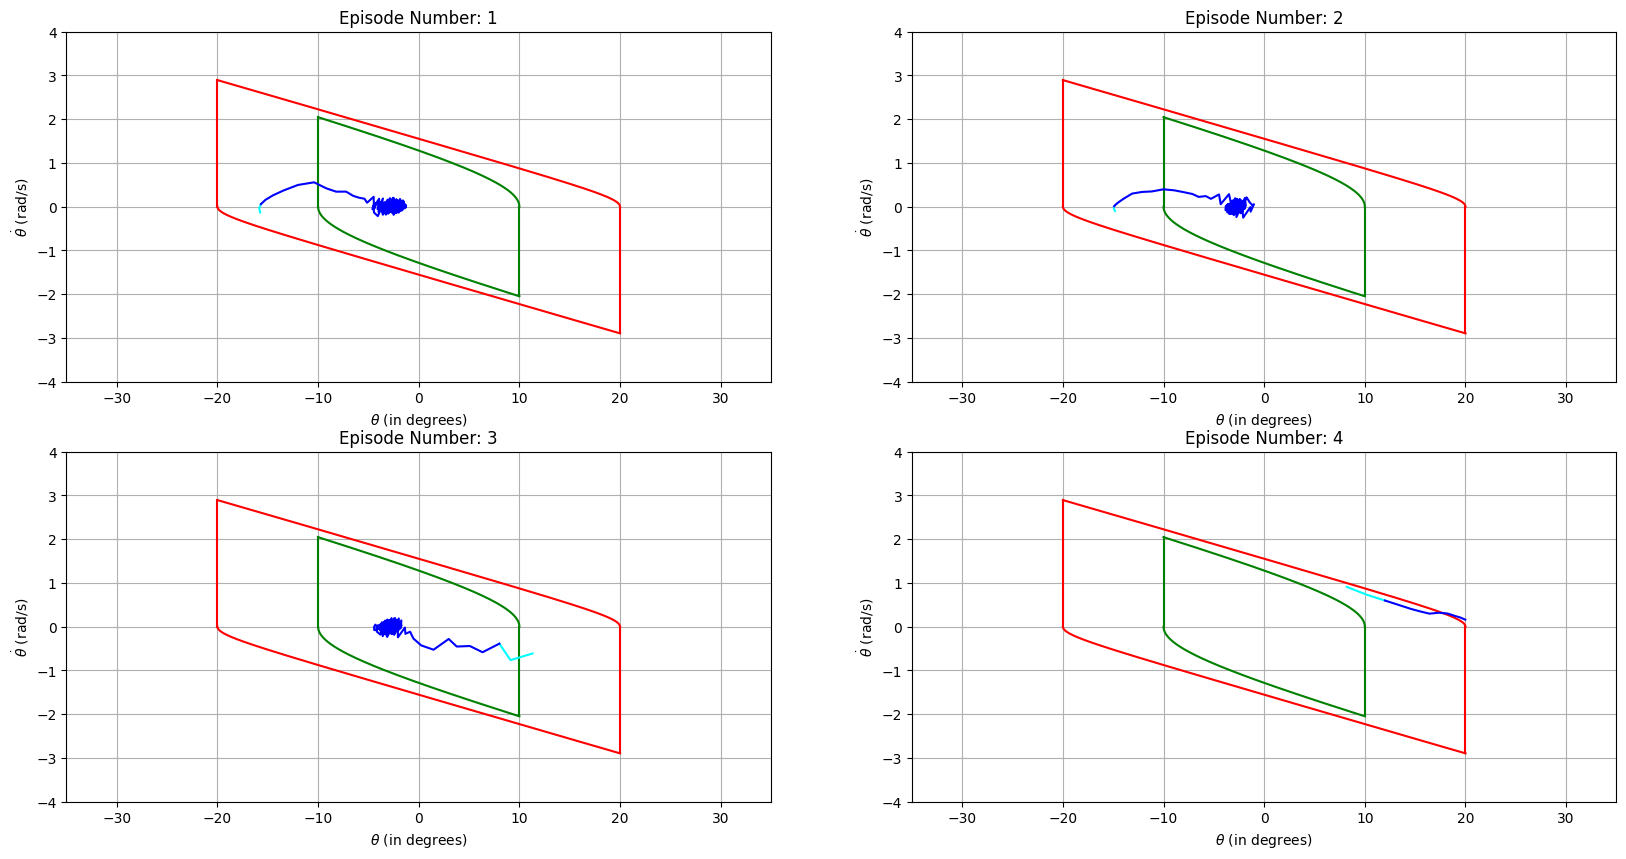

No Safe Set


In [ ]:
rows=2
cols=2
info = info_test

fig,axes = plt.subplots(rows,cols,figsize=(20,10))

episodes = list(range(1,6))
episode_index = 0
for i in range(rows):
    for j in range(cols):
        episode = episodes[episode_index]
        episode_index+=1

        ax = axes[i][j]
        theta0 = config_dict['angle_threshold']*np.pi/180
        ax = plot_safe_set(theta0,ax,color='red')


        theta0 = config_dict['angle_threshold_epsilon']*np.pi/180
        ax = plot_safe_set(theta0,ax,color='green')

        color_split_steps = 2
        ax.plot(info['angle_trajectories'][episode][:color_split_steps+1],info['velocity_trajectories'][episode][:color_split_steps+1],color='cyan')
        ax.plot(info['angle_trajectories'][episode][color_split_steps:],info['velocity_trajectories'][episode][color_split_steps:],color='blue')
        ax.set_title('Episode Number: {}'.format(episode))
plt.show()
print("No Safe Set")

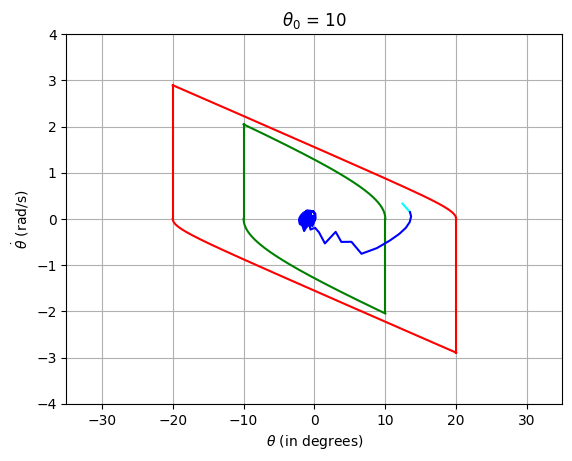

In [ ]:
episode = 11
info = info_test
fig,ax = plt.subplots()

theta0 = config_dict['angle_threshold']*np.pi/180
ax = plot_safe_set(theta0,ax,color='red')


theta0 = config_dict['angle_threshold_epsilon']*np.pi/180
ax = plot_safe_set(theta0,ax,color='green')

color_split_steps = 2
ax.plot(info['angle_trajectories'][episode][:color_split_steps+1],info['velocity_trajectories'][episode][:color_split_steps+1],color='cyan')
ax.plot(info['angle_trajectories'][episode][color_split_steps:],info['velocity_trajectories'][episode][color_split_steps:],color='blue')
plt.show()


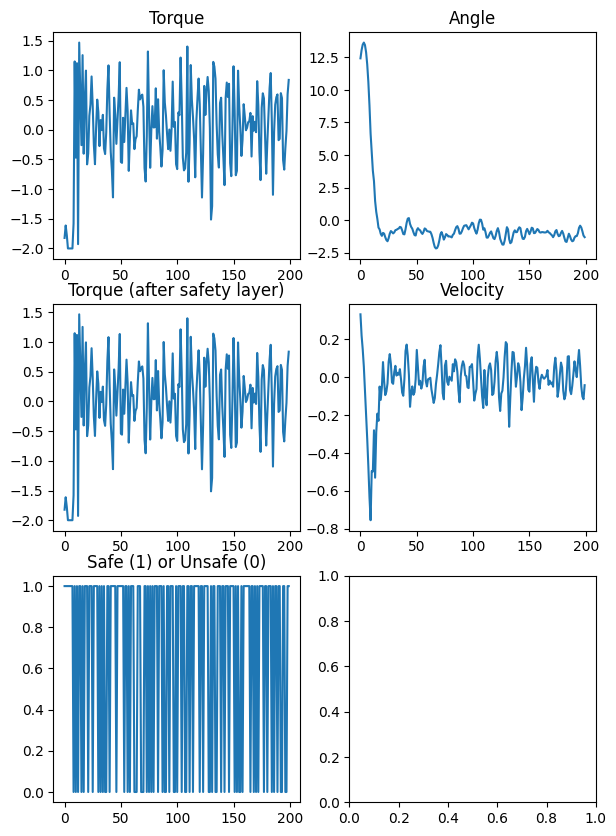

In [ ]:
episode = 11
info = info_test

window = [0,200]
fig,ax = plt.subplots(2,2,figsize=(7,10))
ax[0,0].plot(info['action_trajectories'][episode][window[0]:window[1]])
ax[0,0].set_title('Torque')

ax[1,0].plot(info['action_trajectories_after_safety_layer'][episode][window[0]:window[1]])
ax[1,0].set_title('Torque (after safety layer)'

ax[0,1].plot(info['angle_trajectories'][episode][window[0]:window[1]])
ax[0,1].set_title('Angle')

ax[1,1].plot(info['velocity_trajectories'][episode][window[0]:window[1]])
ax[1,1].set_title('Velocity')
plt.show()

## Full State Space (Misc.)

In [ ]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

class DDPGagent:

    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000,angle_threshold = 20):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        self.env = env
        self.angle_threshold = angle_threshold

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        assert self.env.action_space.high[0]==2

        return self.env.action_space.high[0]*action # Coz the output of the policy network is between -1,1 (added on 4/10/2023)

    def is_safe(self,state,action):

        assert len(state)==3

        angle = np.arctan2(state[1],state[0])*180/np.pi
        angle_threshold = self.angle_threshold
        safety = 1

        # if abs(angle)<angle_threshold:
        if action*angle>0: #if both action and the angle have same sign
            safety = 0
        # if abs(angle)>angle_threshold:
        #     if action*angle>0: #if both action and the angle have same sign
        #         safety = 0


        return safety

    def get_safe_action(self,state,action,epsilon=0.1):

        assert len(state)==3

        safety = self.is_safe(state,action)
        if safety:
            return action
        else:

            resolution = 100
            action_range = self.env.action_space.high[0]

            probab = np.random.uniform(0,1)
            if probab<epsilon:
                if action[0]<=0:
                    action = np.random.uniform(0,action_range)

                else:
                    action = np.random.uniform(0,-action_range)

                return np.array([action])


            if action[0]<=0:
                safe_action_space = torch.linspace(0,action_range,resolution).unsqueeze(1)
                #We need the safe action set in the direction opposite to angle deviation

            else:
                safe_action_space = torch.linspace(0,-action_range,resolution).unsqueeze(1)



            state_tensor = Variable(torch.from_numpy(state).float().unsqueeze(0))
            state_concat = torch.cat([state_tensor] * resolution, dim=0) #Stacked Tensor with same state value to pass into critic

            Qvals = self.critic.forward(state_concat, safe_action_space)
            action_index = torch.argmax(Qvals)

            #action is a (1,1) shaped ndarray below
            action = safe_action_space[action_index].detach().numpy() #finding the action with highest Q value
            return action

    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Critic loss
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()

        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        # Update the noise state according to the Ornstein-Uhlenbeck process
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

def get_angle(state):
    return (np.arctan2(state[1],state[0])*180/np.pi)


def run_algo(config_dict):
    batch_size = config_dict['batch_size']
    hidden_size = config_dict['hidden_size']
    num_episodes = config_dict['num_episodes']
    angle_threshold = config_dict['angle_threshold']
    angle_threshold_start = config_dict['angle_threshold_start']
    ensure_safe_set = config_dict['ensure_safe_set'] # Safe, Partially Safe, No Safe Action Set
    safety_ratio = config_dict['safety_ratio']
    num_time_steps = config_dict['num_time_steps']
    safe_action_epsilon = config_dict['safe_action_epsilon']

    assert ensure_safe_set == 'safe' or ensure_safe_set == 'partially_safe' or ensure_safe_set =='no safe set'

    if config_dict['wandb_log']:
        wandb.init(
            # set the wandb project where this run will be logged
            project="ddpg",

            # track hyperparameters and run metadata
            config=config_dict
        )

    env = gym.make("Pendulum-v1",render_mode = 'rgb_array')
    agent = DDPGagent(env,hidden_size=hidden_size,angle_threshold = angle_threshold)
    noise = OUNoise(env.action_space)

    rewards = []

    starting_angles = []
    average_action_list = []
    average_angle_list = []
    average_reward_list = []
    steps_list = []
    average_safe_action_list = []

    episode = 0
    while episode < num_episodes:
        state,_ = env.reset()

        if abs(get_angle(state))>angle_threshold_start:
            # Ensuring that the episode starts in a safe state
            continue
        else:
            episode += 1
            starting_angle = (np.arctan2(state[1],state[0])*180/np.pi)


            starting_angles.append(starting_angle) # Data Collection
            assert abs(starting_angle)<angle_threshold

            noise.reset()
            episode_reward = 0
            within_threshold_count = 0
            action_within_threshold = 0
            safe_action_count_within_threshold = 0
            angle_sum = 0
            action_sum = 0
            step = 0
            num_safe_actions = 0
            while True:
                step+=1
                angle = np.arctan2(state[1],state[0])*180/np.pi
                angle_sum += abs(angle)

                action = agent.get_action(state) # This is scalar
                action = noise.get_action(action, step) # This is a numpy array

                if action*angle<=0: #Must be less than or equal to
                    num_safe_actions+=1

                if ensure_safe_set=='safe':
                    action = agent.get_safe_action(state,action,safe_action_epsilon)
                    assert agent.is_safe(state,action)==1

                elif ensure_safe_set == 'partially_safe':
                    if np.random.uniform(0,1) < safety_ratio:
                        action = agent.get_safe_action(state,action,safe_action_epsilon)

                #logging
                action_sum += abs(action[0])


                new_state, reward, done, truncated,_ = env.step(action)

                if get_angle(new_state)>angle_threshold:
                    # If the state goes outside the safe set, the episode is terminated
                    done = True

                agent.memory.push(state, action, reward, new_state, done)

                if len(agent.memory) > batch_size:
                    agent.update(batch_size)

                state = new_state
                episode_reward += reward

                if done or truncated:


                    # Logging
                    average_action = action_sum/step
                    average_angle = angle_sum/step
                    average_reward = episode_reward/step
                    average_num_safe_action = num_safe_actions/step

                    steps_list.append(step)
                    average_angle_list.append(average_angle)
                    average_action_list.append(average_action)
                    average_reward_list.append(average_reward)
                    average_safe_action_list.append(average_num_safe_action*100)

                    if config_dict['wandb_log']:

                        wandb.log({'Steps':step,
                                   'Average Reward':average_reward,
                                   'Average Angle':average_angle,
                                   'Average Action (Torque)':average_action,
                                   'Starting Angle':starting_angle,
                                   'Percent Safe Action':average_num_safe_action*100})

                    print("Episode: {} | Steps: {} | Average Reward: {:.2f} | Average Angle: {:.2f} | Average Action (Torque): {:.2f} | Starting Angle: {:.2f} | Percent Safe Action : {:.2f}".format(episode,step,
                                                                                                                                                               average_reward,
                                                                                                                                                               average_angle,
                                                                                                                                                               average_action,
                                                                                                                                                               starting_angle,
                                                                                                                                                               average_num_safe_action*100))

                    break






    plt.plot(steps_list)
    # plt.plot(average_reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.show()

    info_train = {'starting_angles':starting_angles,
            'average_angle':average_angle_list,
            'average_action':average_action_list,
            'steps_list':steps_list,
            'average_rewards':average_reward_list,
            'percent_safe_action':average_num_safe_action*100}
   #### TESTING PHASE #####

    rewards = []

    starting_angles = []
    average_action_list = []
    average_angle_list = []
    average_reward_list = []
    steps_list = []
    average_safe_action_list = []

    episode = 0
    while episode < num_episodes//2:
        state,_ = env.reset()

        if abs(get_angle(state))>angle_threshold_start:
            # Ensuring that the episode starts in a safe state
            continue
        else:
            episode += 1
            starting_angle = (np.arctan2(state[1],state[0])*180/np.pi)


            starting_angles.append(starting_angle) # Data Collection
            assert abs(starting_angle)<angle_threshold

            # noise.reset()
            episode_reward = 0
            within_threshold_count = 0
            action_within_threshold = 0
            safe_action_count_within_threshold = 0
            angle_sum = 0
            action_sum = 0
            step = 0
            num_safe_actions = 0
            while True:
                step+=1
                angle = np.arctan2(state[1],state[0])*180/np.pi
                angle_sum += abs(angle)

                action = agent.get_action(state) # This is scalar
                action = np.array([action])
                # action = noise.get_action(action, step) # This is a numpy array

                if action*angle<=0: #Must be less than or equal to i.e complement of action*angle>0 for unsafe
                    num_safe_actions+=1

                # if ensure_safe_set=='safe':
                #     action = agent.get_safe_action(state,action,safe_action_epsilon)
                #     assert agent.is_safe(state,action)==1

                # elif ensure_safe_set == 'partially_safe':
                #     if np.random.uniform(0,1) < safety_ratio:
                #         action = agent.get_safe_action(state,action,safe_action_epsilon)

                #logging
                action_sum += abs(action[0])


                new_state, reward, done, truncated,_ = env.step(action)

                if get_angle(new_state)>angle_threshold:
                    # If the state goes outside the safe set, the episode is terminated
                    done = True

                # agent.memory.push(state, action, reward, new_state, done)

                # if len(agent.memory) > batch_size:
                #     agent.update(batch_size)

                state = new_state
                episode_reward += reward

                if done or truncated:


                    # Logging
                    average_action = action_sum/step
                    average_angle = angle_sum/step
                    average_reward = episode_reward/step
                    average_num_safe_action = num_safe_actions/step

                    steps_list.append(step)
                    average_angle_list.append(average_angle)
                    average_action_list.append(average_action)
                    average_reward_list.append(average_reward)
                    average_safe_action_list.append(average_num_safe_action*100)

                    if config_dict['wandb_log']:

                        wandb.log({'Test/Steps':step,
                                   'Test/Average Reward':average_reward,
                                   'Test/Average Angle':average_angle,
                                   'Test/Average Action (Torque)':average_action,
                                   'Test/Starting Angle':starting_angle,
                                   'Test/Percent Safe Action':average_num_safe_action*100})

                    print("TESTING PHASE || Episode: {} | Steps: {} | Average Reward: {:.2f} | Average Angle: {:.2f} | Average Action (Torque): {:.2f} | Starting Angle: {:.2f} | Percent Safe Action : {:.2f}".format(episode,step,
                                                                                                                                                               average_reward,
                                                                                                                                                               average_angle,
                                                                                                                                                               average_action,
                                                                                                                                                               starting_angle,
                                                                                                                                                               average_num_safe_action*100))

                    break






    if config_dict['wandb_log']:
        wandb.finish()



    plt.plot(steps_list)
    # plt.plot(average_reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.show()

    info_test = {'starting_angles':starting_angles,
            'average_angle':average_angle_list,
            'average_action':average_action_list,
            'steps_list':steps_list,
            'average_rewards':average_reward_list,
            'percent_safe_action':average_num_safe_action*100}








    if config_dict['wandb_log']:
        wandb.finish()





    ''
    return agent, noise, env, info_train

## Only Safe Set Space

In [ ]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

class DDPGagent:

    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000,angle_threshold = 20,angle_threshold_epsilon=5):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        self.env = env
        self.angle_threshold = angle_threshold
        self.angle_threshold_epsilon = angle_threshold_epsilon

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        assert self.env.action_space.high[0]==2

        return self.env.action_space.high[0]*action # Coz the output of the policy network is between -1,1 (added on 4/10/2023)

    def is_safe(self,state,action):

        assert len(state)==3

        angle = np.arctan2(state[1],state[0])*180/np.pi
        angle_threshold = self.angle_threshold
        safety = 1

        # if abs(angle)<angle_threshold:
        if abs(angle)<self.angle_threshold_epsilon:
            if action*state[2]>0:
                safety = 0

        else:
            if action*angle>=0: #if both action and the angle have same sign
                safety = 0
        # if abs(angle)>angle_threshold:
        #     if action*angle>0: #if both action and the angle have same sign
        #         safety = 0


        return safety

    def get_safe_action(self,state,action,epsilon=0.1):

        # assert len(state)==3

        # safety = self.is_safe(state,action)
        # if safety:
        #     return action
        # else:


        angle = np.arctan2(state[1],state[0])*180/np.pi
        action_range = self.env.action_space.high[0]

        if abs(angle)<self.angle_threshold_epsilon:
            if state[2]>0:
                action = -action_range
            elif state[2]<0:
                action = action_range
            else:
                action = 0

        else:
            if angle>0:
                action = -action_range
            else:
                action = action_range

        return np.array([action])

            # if action>0:
            #     return np.array([-self.env.action_space.high[0]])

            # elif action<0:
            #     return np.array([self.env.action_space.high[0]])

            # elif action==0:
            #     if angle>0:
            #         return np.array([-self.env.action_space.high[0]])
            #     else:
            #         return np.array([self.env.action_space.high[0]])


            # resolution = 100
            # zero_tol = 0.01
            # action_range = self.env.action_space.high[0]

            # probab = np.random.uniform(0,1)
            # if probab<epsilon:
            #     if action[0]<=0:
            #         action = np.random.uniform(zero_tol,action_range)

            #     else:
            #         action = np.random.uniform(-zero_tol,-action_range)

            #     return np.array([action])


            # if action[0]<=0:
            #     safe_action_space = torch.linspace(zero_tol,action_range,resolution).unsqueeze(1)
            #     #We need the safe action set in the direction opposite to angle deviation

            # else:
            #     safe_action_space = torch.linspace(-zero_tol,-action_range,resolution).unsqueeze(1)



            # state_tensor = Variable(torch.from_numpy(state).float().unsqueeze(0))
            # state_concat = torch.cat([state_tensor] * resolution, dim=0) #Stacked Tensor with same state value to pass into critic

            # Qvals = self.critic.forward(state_concat, safe_action_space)
            # action_index = torch.argmax(Qvals)

            # #action is a (1,1) shaped ndarray below
            # action = safe_action_space[action_index].detach().numpy() #finding the action with highest Q value
            # return action

    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Critic loss
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()

        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        # Update the noise state according to the Ornstein-Uhlenbeck process
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

def get_angle(state):
    return (np.arctan2(state[1],state[0])*180/np.pi)


def run_algo(config_dict):
    batch_size = config_dict['batch_size']
    hidden_size = config_dict['hidden_size']
    num_episodes = config_dict['num_episodes']
    num_episodes_test = config_dict['num_episodes_test']
    angle_threshold = config_dict['angle_threshold']
    angle_threshold_start = config_dict['angle_threshold_start']
    velocity_threshold_start = config_dict['velocity_threshold_start']
    ensure_safe_set = config_dict['ensure_safe_set'] # Safe, Partially Safe, No Safe Action Set
    safety_ratio = config_dict['safety_ratio']
    num_time_steps = config_dict['num_time_steps']
    safe_action_epsilon = config_dict['safe_action_epsilon']
    angle_threshold_epsilon = config_dict['angle_threshold_epsilon']

    assert ensure_safe_set == 'safe' or ensure_safe_set == 'partially_safe' or ensure_safe_set =='no safe set'

    if config_dict['wandb_log']:
        wandb.init(
            # set the wandb project where this run will be logged
            project="ddpg",

            # track hyperparameters and run metadata
            config=config_dict
        )

    env = gym.make("Pendulum-v1",render_mode = 'rgb_array')
    agent = DDPGagent(env,hidden_size=hidden_size,angle_threshold = angle_threshold,angle_threshold_epsilon=angle_threshold_epsilon)
    noise = OUNoise(env.action_space)

    rewards = []

    starting_angles = [] #The angle with which the episode starts
    starting_velocities = [] #The velocity with which the episode starts
    average_action_list = [] #The average torque in an episode
    average_angle_list = []  #The average angle in an episode
    average_reward_list = [] #The average reward in an episode
    steps_list = []          #Stores the number of steps in each episode
    average_safe_action_list = [] #Stores the percentage of safe action generated before the safety layer intervention
    action_trajectories = {} # Stores the action trajectory for each episode
    safe_action_flag_trajectories = {}

    angle_trajectories = {}  # Stores the angle trajectory for each episode
    action_trajectories_after_safety_layer = {} # Stores the velocity trajectory for each episode
    velocity_trajectories = {}
    # safety_violations_list = []

    episode = 0
    while episode < num_episodes:


        state,_ = env.reset()

        if abs(get_angle(state))>angle_threshold_start or (abs(get_angle(state))<=angle_threshold_start and abs(state[2])>velocity_threshold_start):
            # Ensuring that the episode starts in a safe state
            continue
        else:
            action_trajectory = []
            safe_action_flag_trajectory = []

            angle_trajectory = []
            velocity_trajectory = []
            action_trajectory_after_safety_layer = []

            episode += 1
            starting_angle = (np.arctan2(state[1],state[0])*180/np.pi)
            starting_velocity = state[2]


            starting_angles.append(starting_angle) # Data Collection
            starting_velocities.append(starting_velocity)

            assert abs(starting_angle)<angle_threshold

            noise.reset()
            episode_reward = 0
            within_threshold_count = 0
            action_within_threshold = 0
            safe_action_count_within_threshold = 0
            angle_sum = 0
            action_sum = 0
            step = 0
            num_safe_actions = 0
            num_safe_actions_old = 0
            # safety_violations = 0

            while True:
                step+=1
                angle = np.arctan2(state[1],state[0])*180/np.pi
                angle_sum += abs(angle)

                action = agent.get_action(state) # This is scalar
                action = noise.get_action(action, step) # This is a numpy array

                action_trajectory.append(action[0])
                angle_trajectory.append(angle)
                velocity_trajectory.append(state[2])

                # if agent.is_safe(state,action[0])==1:
                #     num_safe_actions+=1

                if action*angle<=0: #Must be less than or equal to i.e complement of action*angle>0 for unsafe
                    num_safe_actions_old+=1


                if ensure_safe_set=='safe':
                    action = agent.get_safe_action(state,action,safe_action_epsilon)
                    assert agent.is_safe(state,action)==1

                elif ensure_safe_set == 'partially_safe':
                    if np.random.uniform(0,1) < safety_ratio:
                        action = agent.get_safe_action(state,action,safe_action_epsilon)


                if agent.is_safe(state,action[0])==1:
                    num_safe_actions+=1
                safe_action_flag_trajectory.append(agent.is_safe(state,action[0]))

                action_trajectory_after_safety_layer.append(action[0])

                #logging
                action_sum += abs(action[0])


                new_state, reward, done, truncated,_ = env.step(action)

                if abs(get_angle(new_state))>angle_threshold:
                    # safety_violations+=1
                    done = True

                agent.memory.push(state, action, reward, new_state, done)

                if len(agent.memory) > batch_size:
                    agent.update(batch_size)

                state = new_state
                episode_reward += reward

                if done or truncated:


                    # Logging
                    average_action = action_sum/step
                    average_angle = angle_sum/step
                    average_reward = episode_reward/step
                    average_num_safe_action = num_safe_actions/step
                    average_num_safe_action_old = num_safe_actions_old/step

                    steps_list.append(step)
                    average_angle_list.append(average_angle)
                    average_action_list.append(average_action)
                    average_reward_list.append(average_reward)
                    average_safe_action_list.append(average_num_safe_action*100)
                    # safety_violations_list.append(safety_violations)

                    if config_dict['wandb_log']:

                        wandb.log({'Steps':step,
                                   'Average Reward':average_reward,
                                   'Average Angle':average_angle,
                                   'Average Action (Torque)':average_action,
                                   'Starting Angle':starting_angle,
                                   'Starting Velocity':starting_velocity,
                                   'Percent Safe Action':average_num_safe_action*100,
                                   'Percent Safe Action (Only Angle)':average_num_safe_action_old*100})
                                #    'Safety Violations':safety_violations})

                    print("Episode: {} | Steps: {} | Average Reward: {:.2f} | Average Angle: {:.2f} | Average Action (Torque): {:.2f} | Starting Angle: {:.2f} | Starting Velocity: {:.2f} "
                          "| Percent Safe Action : {:.2f} | Percent Safe Action (Old) : {:.2f}".format(episode,step,
                                                                                                        average_reward,
                                                                                                        average_angle,
                                                                                                        average_action,
                                                                                                        starting_angle,
                                                                                                       starting_velocity,
                                                                                                        average_num_safe_action*100,
                                                                                                        average_num_safe_action_old*100))

                    break

            action_trajectories[episode] = action_trajectory
            angle_trajectories[episode] = angle_trajectory
            velocity_trajectories[episode] = velocity_trajectory
            action_trajectories_after_safety_layer[episode] = action_trajectory_after_safety_layer
            safe_action_flag_trajectories[episode] = safe_action_flag_trajectory








    plt.plot(steps_list)
    # plt.plot(average_reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.show()

    info_train = {'starting_angles':starting_angles,
            'average_angle':average_angle_list,
            'average_action':average_action_list,
            'steps_list':steps_list,
            'average_rewards':average_reward_list,
            'percent_safe_action':average_num_safe_action*100,
            'action_trajectories':action_trajectories,
            'angle_trajectories':angle_trajectories,
            'velocity_trajectories':velocity_trajectories,
            'action_trajectories_after_safety_layer':action_trajectories_after_safety_layer,
            'safe_action_flag_trajectories':safe_action_flag_trajectories}


############################### TESTING PHASE #############################

    rewards = []

    starting_angles = [] #The angle with which the episode starts
    starting_velocities = [] #The velocity with which the episode starts
    average_action_list = [] #The average torque in an episode
    average_angle_list = []  #The average angle in an episode
    average_reward_list = [] #The average reward in an episode
    steps_list = []          #Stores the number of steps in each episode
    average_safe_action_list = [] #Stores the percentage of safe action generated before the safety layer intervention
    action_trajectories = {} # Stores the action trajectory for each episode
    safe_action_flag_trajectories = {}
    angle_trajectories = {}  # Stores the angle trajectory for each episode
    action_trajectories_after_safety_layer = {} # Stores the velocity trajectory for each episode

    velocity_trajectories = {}
    # safety_violations_list = []

    episode = 0
    while episode < num_episodes_test:


        state,_ = env.reset()

        if abs(get_angle(state))>angle_threshold_start or (abs(get_angle(state))<=angle_threshold_start and abs(state[2])>velocity_threshold_start):
            # Ensuring that the episode starts in a safe state
            continue
        else:
            action_trajectory = []
            safe_action_flag_trajectory = []
            angle_trajectory = []
            velocity_trajectory = []
            action_trajectory_after_safety_layer = []

            episode += 1
            starting_angle = (np.arctan2(state[1],state[0])*180/np.pi)
            starting_velocity = state[2]


            starting_angles.append(starting_angle) # Data Collection
            starting_velocities.append(starting_velocity)

            assert abs(starting_angle)<angle_threshold

            noise.reset()
            episode_reward = 0
            within_threshold_count = 0
            action_within_threshold = 0
            safe_action_count_within_threshold = 0
            angle_sum = 0
            action_sum = 0
            step = 0
            num_safe_actions = 0
            num_safe_actions_old = 0
            # safety_violations = 0

            while True:
                step+=1
                angle = np.arctan2(state[1],state[0])*180/np.pi
                angle_sum += abs(angle)

                action = agent.get_action(state) # This is scalar
                action = noise.get_action(action, step) # This is a numpy array

                action_trajectory.append(action[0])
                angle_trajectory.append(angle)
                velocity_trajectory.append(state[2])
                safe_action_flag_trajectory.append(agent.is_safe(state,action))


                # if agent.is_safe(state,action)==1:
                #     num_safe_actions+=1

                if action*angle<=0: #Must be less than or equal to i.e complement of action*angle>0 for unsafe
                    num_safe_actions_old+=1


                # if ensure_safe_set=='safe':
                #     action = agent.get_safe_action(state,action,safe_action_epsilon)
                #     assert agent.is_safe(state,action)==1

                # elif ensure_safe_set == 'partially_safe':
                #     if np.random.uniform(0,1) < safety_ratio:
                #         action = agent.get_safe_action(state,action,safe_action_epsilon)

                if agent.is_safe(state,action)==1:
                    num_safe_actions+=1
                action_trajectory_after_safety_layer.append(action[0])

                #logging
                action_sum += abs(action[0])


                new_state, reward, done, truncated,_ = env.step(action)

                if abs(get_angle(new_state))>angle_threshold:
                    # safety_violations+=1
                    done = True

                # agent.memory.push(state, action, reward, new_state, done)

                # if len(agent.memory) > batch_size:
                #     agent.update(batch_size)

                state = new_state
                episode_reward += reward

                if done or truncated:


                    # Logging
                    average_action = action_sum/step
                    average_angle = angle_sum/step
                    average_reward = episode_reward/step
                    average_num_safe_action = num_safe_actions/step
                    average_num_safe_action_old = num_safe_actions_old/step

                    steps_list.append(step)
                    average_angle_list.append(average_angle)
                    average_action_list.append(average_action)
                    average_reward_list.append(average_reward)
                    average_safe_action_list.append(average_num_safe_action*100)
                    # safety_violations_list.append(safety_violations)

                    if config_dict['wandb_log']:

                        wandb.log({'Test/Steps':step,
                                   'Test/Average Reward':average_reward,
                                   'Test/Average Angle':average_angle,
                                   'Test/Average Action (Torque)':average_action,
                                   'Test/Starting Angle':starting_angle,
                                   'Test/Starting Velocity':starting_velocity,
                                   'Test/Percent Safe Action':average_num_safe_action*100,
                                   'Test/Percent Safe Action (Only Angle)':average_num_safe_action_old*100})
                                #    'Safety Violations':safety_violations})

                    print("Episode: {} | Steps: {} | Average Reward: {:.2f} | Average Angle: {:.2f} | Average Action (Torque): {:.2f} | Starting Angle: {:.2f} | Starting Velocity: {:.2f} "
                          "| Percent Safe Action : {:.2f} | Percent Safe Action (Old) : {:.2f}".format(episode,step,
                                                                                                        average_reward,
                                                                                                        average_angle,
                                                                                                        average_action,
                                                                                                        starting_angle,
                                                                                                       starting_velocity,
                                                                                                        average_num_safe_action*100,
                                                                                                        average_num_safe_action_old*100))

                    break

            action_trajectories[episode] = action_trajectory
            angle_trajectories[episode] = angle_trajectory
            velocity_trajectories[episode] = velocity_trajectory
            action_trajectories_after_safety_layer[episode] = action_trajectory_after_safety_layer
            safe_action_flag_trajectories[episode] = safe_action_flag_trajectory



    info_test = {'starting_angles':starting_angles,
            'average_angle':average_angle_list,
            'average_action':average_action_list,
            'steps_list':steps_list,
            'average_rewards':average_reward_list,
            'percent_safe_action':average_num_safe_action*100,
            'action_trajectories':action_trajectories,
            'angle_trajectories':angle_trajectories,
            'velocity_trajectories':velocity_trajectories,
            'action_trajectories_after_safety_layer':action_trajectories_after_safety_layer,
            'safe_action_flag_trajectories':safe_action_flag_trajectories}




    if config_dict['wandb_log']:
        wandb.finish()



    plt.plot(steps_list)
    # plt.plot(average_reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.show()


    if config_dict['wandb_log']:
        wandb.finish()


    return agent, noise, env, info_train, info_test

wandb: Currently logged in as: crna. Use `wandb login --relogin` to force relogin


Episode: 1 | Steps: 20 | Average Reward: -0.08 | Average Angle: 6.75 | Average Action (Torque): 0.38 | Starting Angle: -2.56 | Starting Velocity: 0.58 | Percent Safe Action : 50.00 | Percent Safe Action (Old) : 35.00
Episode: 2 | Steps: 12 | Average Reward: -0.13 | Average Angle: 16.76 | Average Action (Torque): 0.50 | Starting Angle: 12.15 | Starting Velocity: -0.05 | Percent Safe Action : 75.00 | Percent Safe Action (Old) : 75.00
Episode: 3 | Steps: 16 | Average Reward: -0.11 | Average Angle: 8.71 | Average Action (Torque): 0.54 | Starting Angle: -6.25 | Starting Velocity: 0.55 | Percent Safe Action : 25.00 | Percent Safe Action (Old) : 0.00
Episode: 4 | Steps: 13 | Average Reward: -0.16 | Average Angle: 7.22 | Average Action (Torque): 0.83 | Starting Angle: 2.22 | Starting Velocity: -0.24 | Percent Safe Action : 7.69 | Percent Safe Action (Old) : 23.08
Episode: 5 | Steps: 13 | Average Reward: -0.11 | Average Angle: 8.85 | Average Action (Torque): 0.25 | Starting Angle: 1.23 | Starti

<ipython-input-7-fb4ab1eec104>:174: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.FloatTensor(states)


Episode: 11 | Steps: 6 | Average Reward: -0.19 | Average Angle: 18.80 | Average Action (Torque): 0.33 | Starting Angle: -13.91 | Starting Velocity: -0.19 | Percent Safe Action : 16.67 | Percent Safe Action (Old) : 16.67
Episode: 12 | Steps: 8 | Average Reward: -0.19 | Average Angle: 20.00 | Average Action (Torque): 0.53 | Starting Angle: 13.94 | Starting Velocity: 0.09 | Percent Safe Action : 87.50 | Percent Safe Action (Old) : 87.50
Episode: 13 | Steps: 13 | Average Reward: -0.14 | Average Angle: 7.24 | Average Action (Torque): 0.78 | Starting Angle: 0.46 | Starting Velocity: 0.07 | Percent Safe Action : 7.69 | Percent Safe Action (Old) : 23.08
Episode: 14 | Steps: 11 | Average Reward: -0.13 | Average Angle: 13.91 | Average Action (Torque): 0.37 | Starting Angle: -6.71 | Starting Velocity: 0.06 | Percent Safe Action : 54.55 | Percent Safe Action (Old) : 54.55
Episode: 15 | Steps: 10 | Average Reward: -0.15 | Average Angle: 15.11 | Average Action (Torque): 0.33 | Starting Angle: 7.00 |

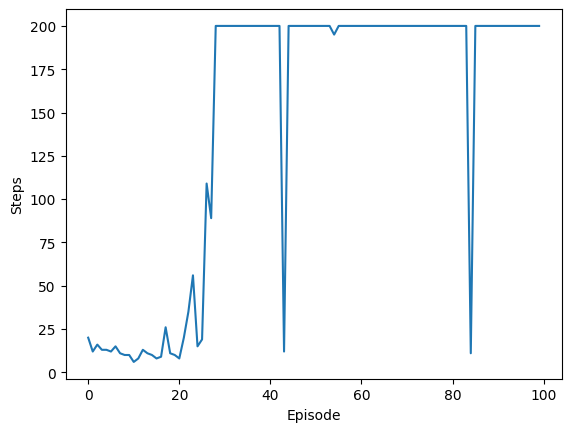

Episode: 1 | Steps: 200 | Average Reward: -0.00 | Average Angle: 1.66 | Average Action (Torque): 1.19 | Starting Angle: -2.30 | Starting Velocity: -0.32 | Percent Safe Action : 91.00 | Percent Safe Action (Old) : 57.00
Episode: 2 | Steps: 200 | Average Reward: -0.00 | Average Angle: 1.15 | Average Action (Torque): 1.12 | Starting Angle: -0.99 | Starting Velocity: 0.21 | Percent Safe Action : 91.00 | Percent Safe Action (Old) : 56.50
Episode: 3 | Steps: 200 | Average Reward: -0.00 | Average Angle: 1.25 | Average Action (Torque): 1.35 | Starting Angle: 4.86 | Starting Velocity: 0.26 | Percent Safe Action : 93.00 | Percent Safe Action (Old) : 52.00
Episode: 4 | Steps: 200 | Average Reward: -0.00 | Average Angle: 1.08 | Average Action (Torque): 1.06 | Starting Angle: 0.04 | Starting Velocity: 0.45 | Percent Safe Action : 90.00 | Percent Safe Action (Old) : 58.00
Episode: 5 | Steps: 200 | Average Reward: -0.01 | Average Angle: 2.11 | Average Action (Torque): 1.24 | Starting Angle: 9.00 | St

Average Action (Torque),▁▂▁▃▁▃▅▂▃▁▆▆▂▃▃▂▂▇▃▂▂▇▇▆▇████▇▇▆▇▆▆▆▆▅▆▅
Average Angle,▃▄▅▇▇▃▅▃█▂▇▆▁▁▁▁▂█▂▁▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁▂▂▁▁▁
Average Reward,▆▅▅▄▃▅▁▆▄▇▅▆█████▄██████████████████████
Percent Safe Action,▅▃▃█▂▂▁▃▅▆██▆▇▇▆▆█▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇█
Percent Safe Action (Only Angle),▃▁▃█▂▃▁▅▅▅██▅▅▅▅▅█▅▅▅▅▅▆▆▅▆▅▅▅▅▆▅▅▅▅▅▅▅▅
Starting Angle,▄▃▃█▁▅▄▇▁▄▆▅▅▄▂▆▁▁▁▃▇▃▄▃▄▂▁▇▄▄▅▁▇▄▄▆▇█▆▃
Starting Velocity,██▆▅▃▅▁▁▆██▇▂▇▃▆▂▁▃▇▄▂▅▂▁▁▂▁▃▅▃▃▅▆█▄█▂▆▄
Steps,▂▁▁▁▁▁▁▂▁▂▁▄█████▁██████████████████████
Test/Average Action (Torque),▅▄▇▃▆▅▅▃▄▅▆█▄▇▆▅▄▅▆▂█▄▃▅▄▅▆▇▅▁▄▃▆▃▅▅▅▅▅▄
Test/Average Angle,▃▂▂▁▅▄▂▅▅▃▆▂▁▂▆▄▄▂▅▃▂▆▆▆▄▂▄▃▄▃▃▅▂▂▄▇█▃▄▂
Test/Average Reward,▇█▇█▅▇█▆▆▆▅▇█▇▅▆▅▇▄▇▆▆▁▁▄█▅▇▇▆▇▃▇▇▅▄▁▇▅█


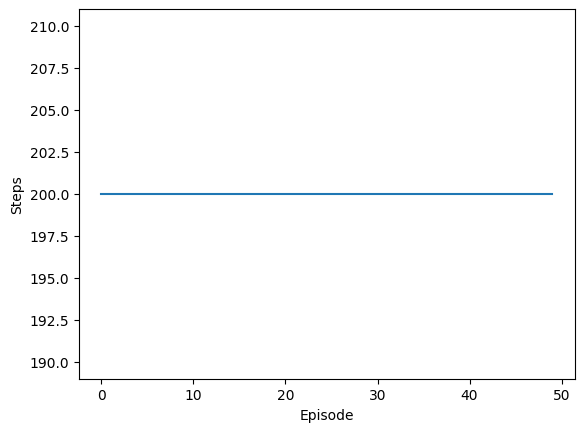

Episode: 1 | Steps: 10 | Average Reward: -0.19 | Average Angle: 11.69 | Average Action (Torque): 1.03 | Starting Angle: -4.47 | Starting Velocity: 0.19 | Percent Safe Action : 20.00 | Percent Safe Action (Old) : 0.00
Episode: 2 | Steps: 9 | Average Reward: -0.19 | Average Angle: 17.28 | Average Action (Torque): 0.56 | Starting Angle: -12.62 | Starting Velocity: 0.43 | Percent Safe Action : 0.00 | Percent Safe Action (Old) : 0.00
Episode: 3 | Steps: 17 | Average Reward: -0.12 | Average Angle: 6.66 | Average Action (Torque): 0.54 | Starting Angle: 1.36 | Starting Velocity: -0.10 | Percent Safe Action : 23.53 | Percent Safe Action (Old) : 35.29
Episode: 4 | Steps: 9 | Average Reward: -0.13 | Average Angle: 15.14 | Average Action (Torque): 0.27 | Starting Angle: 9.64 | Starting Velocity: -0.07 | Percent Safe Action : 33.33 | Percent Safe Action (Old) : 33.33
Episode: 5 | Steps: 9 | Average Reward: -0.13 | Average Angle: 15.29 | Average Action (Torque): 0.21 | Starting Angle: 9.93 | Startin

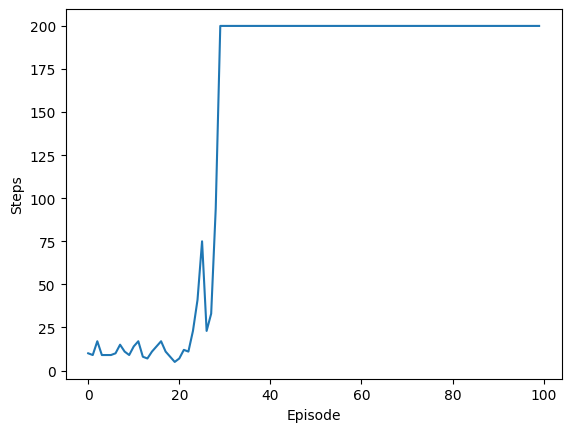

Episode: 1 | Steps: 172 | Average Reward: -0.03 | Average Angle: 7.56 | Average Action (Torque): 1.12 | Starting Angle: 14.26 | Starting Velocity: 0.41 | Percent Safe Action : 77.91 | Percent Safe Action (Old) : 73.84
Episode: 2 | Steps: 200 | Average Reward: -0.02 | Average Angle: 6.18 | Average Action (Torque): 1.16 | Starting Angle: 13.23 | Starting Velocity: -0.33 | Percent Safe Action : 80.00 | Percent Safe Action (Old) : 69.00
Episode: 3 | Steps: 200 | Average Reward: -0.01 | Average Angle: 5.10 | Average Action (Torque): 1.14 | Starting Angle: -13.88 | Starting Velocity: 0.30 | Percent Safe Action : 72.50 | Percent Safe Action (Old) : 61.50
Episode: 4 | Steps: 200 | Average Reward: -0.01 | Average Angle: 5.15 | Average Action (Torque): 1.21 | Starting Angle: 2.12 | Starting Velocity: -0.03 | Percent Safe Action : 77.00 | Percent Safe Action (Old) : 61.50
Episode: 5 | Steps: 200 | Average Reward: -0.01 | Average Angle: 5.05 | Average Action (Torque): 1.16 | Starting Angle: -10.35

Average Action (Torque),▄▂▂▁▄▂▃▇▂▅▂▆▁▃▅▃▅▆▅▅▆▇▇▇▇█▇▇▇▅▇▇▆▆▅▆▆▅▆▆
Average Angle,▅▃▅▄▄▇▇▄▇█▃▇▁▂▂▂▁▁▁▂▂▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▃▃▃▃
Average Reward,▃▅▂▅▃▄▅▁▁▄▇▅████████████████████████████
Percent Safe Action,▂▂▁▁▃▇█▂▅▇▆█▅▆▇▆█▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▆▆▆▆
Percent Safe Action (Only Angle),▁▃▂▃▅▇█▄▅▇▆█▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Starting Angle,▃▅▄▅▇▂▇▅▂▁▅▁▄▂▄██▃▁█▂▄▄▂▆▅▇▃▅▁▂▁▁▂▅▁▂▃█▇
Starting Velocity,▆▄▂▅▁▂▅▆▂▆▃▄▂▅▇█▃▆▄▁▅▅▅▇▇▆█▁█▅▅▇▂▆▆▄█▁▂█
Steps,▁▁▁▁▁▁▁▁▁▁▃▂████████████████████████████
Test/Average Action (Torque),▄▅▄▆▄▇▄▅▃▁▆█▄▅▆▆▄█▃▇▅▇▆▇▇▄▃▁▆█▇▃▆▆▃▅▇▅▃▃
Test/Average Angle,▇▄▂▂▅▂▂▂▃▄▂▂▃▃▂▂▃▃▄▂▂▃▂▂▃▃▁▄▂▁▂▅▁▂▂▂█▂▆▅
Test/Average Reward,▅▇██▆▇██▇▇██▇▇██▇▇▇██▇██▇▇█▆▇██▆████▁█▅▇


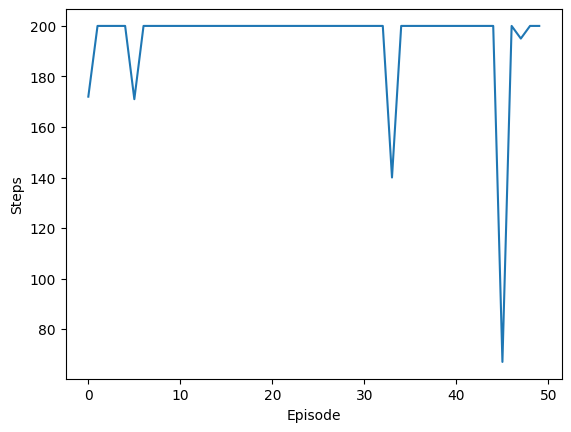

Episode: 1 | Steps: 11 | Average Reward: -0.17 | Average Angle: 15.62 | Average Action (Torque): 0.64 | Starting Angle: -5.17 | Starting Velocity: -0.42 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 100.00
Episode: 2 | Steps: 14 | Average Reward: -0.12 | Average Angle: 13.26 | Average Action (Torque): 0.33 | Starting Angle: 6.94 | Starting Velocity: -0.10 | Percent Safe Action : 92.86 | Percent Safe Action (Old) : 92.86
Episode: 3 | Steps: 10 | Average Reward: -0.17 | Average Angle: 16.54 | Average Action (Torque): 0.34 | Starting Angle: 11.91 | Starting Velocity: -0.36 | Percent Safe Action : 40.00 | Percent Safe Action (Old) : 40.00
Episode: 4 | Steps: 13 | Average Reward: -0.17 | Average Angle: 9.52 | Average Action (Torque): 0.42 | Starting Angle: -5.02 | Starting Velocity: 0.47 | Percent Safe Action : 30.77 | Percent Safe Action (Old) : 53.85
Episode: 5 | Steps: 6 | Average Reward: -0.21 | Average Angle: 18.40 | Average Action (Torque): 0.38 | Starting Angle: -11.74

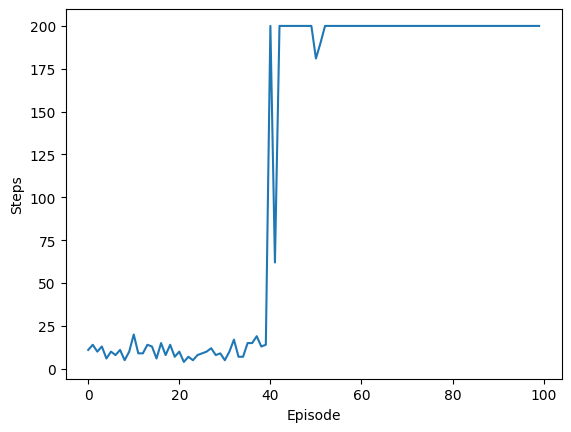

Episode: 1 | Steps: 200 | Average Reward: -0.01 | Average Angle: 4.14 | Average Action (Torque): 1.43 | Starting Angle: -8.83 | Starting Velocity: -0.54 | Percent Safe Action : 86.00 | Percent Safe Action (Old) : 59.00
Episode: 2 | Steps: 200 | Average Reward: -0.01 | Average Angle: 2.91 | Average Action (Torque): 1.52 | Starting Angle: -2.99 | Starting Velocity: -0.57 | Percent Safe Action : 94.00 | Percent Safe Action (Old) : 53.50
Episode: 3 | Steps: 200 | Average Reward: -0.01 | Average Angle: 3.78 | Average Action (Torque): 1.44 | Starting Angle: -13.33 | Starting Velocity: -0.10 | Percent Safe Action : 90.00 | Percent Safe Action (Old) : 57.50
Episode: 4 | Steps: 200 | Average Reward: -0.01 | Average Angle: 2.72 | Average Action (Torque): 1.55 | Starting Angle: 2.77 | Starting Velocity: 0.30 | Percent Safe Action : 93.50 | Percent Safe Action (Old) : 55.50
Episode: 5 | Steps: 200 | Average Reward: -0.01 | Average Angle: 3.39 | Average Action (Torque): 1.36 | Starting Angle: 1.41 

Average Action (Torque),▃▁▁▃▃▁▆▆▇▇▅▅▃▂▄▃▄▂▁▅▅▄▅▇▄▇█▇▇▆▇▃▃▇▇▇▇▇█▇
Average Angle,▆▇▇▅▃▆▅▆▄▇▅▄█▇▆▆▄▂▁▂▂▁▁▁▁▂▁▂▁▁▂▁▂▂▂▁▁▁▂▂
Average Reward,▃▃▄▃▅▄▂▂▃▂▂▄▁▁▅▅▇███████████████████████
Percent Safe Action,█▄▆▂▂▆▁▁▂▁▃▃▅▅▇▇▇▆▅▇▇▇▇█▇▇▇▇▇▇█▆▆▇▇▇▇█▇▇
Percent Safe Action (Only Angle),█▄▆▁▅▆▁▁▄▁▂▆▅▅▇▇█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Starting Angle,▃▇▇▆▃▄▆▆▃▇▅▄█▇▂▃▆▇▄▃▂▇▅▄▇▁▃█▅▂▅▇█▃▃▂█▆▄▇
Starting Velocity,▂▂▄▃▇▁▆▄▅▁▃▃█▇▅▃▂▇▇▇▂▇▁▄▃█▃▆▆▇▃▆▅▆▄▅▂▃▃█
Steps,▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁████▇███████████████████
Test/Average Action (Torque),▃▅▃▅▂▄▃▄▂▄▄▃▁▄▂▃▅▃▃▃▃▄▅▁▃▄▂▃▄▂▂▄▃▄▃▂▅▃█▃
Test/Average Angle,▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂
Test/Average Reward,████████████████▁█████████████████████▁█


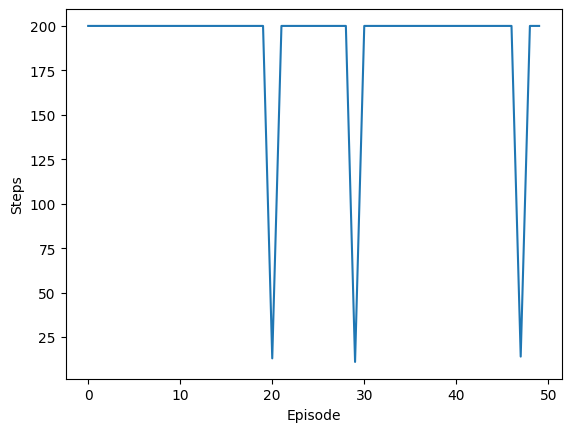

Episode: 1 | Steps: 10 | Average Reward: -0.17 | Average Angle: 16.10 | Average Action (Torque): 0.27 | Starting Angle: 10.43 | Starting Velocity: -0.19 | Percent Safe Action : 10.00 | Percent Safe Action (Old) : 10.00
Episode: 2 | Steps: 9 | Average Reward: -0.19 | Average Angle: 18.47 | Average Action (Torque): 0.50 | Starting Angle: 11.20 | Starting Velocity: 0.08 | Percent Safe Action : 66.67 | Percent Safe Action (Old) : 66.67
Episode: 3 | Steps: 15 | Average Reward: -0.11 | Average Angle: 11.73 | Average Action (Torque): 0.29 | Starting Angle: -3.35 | Starting Velocity: -0.13 | Percent Safe Action : 86.67 | Percent Safe Action (Old) : 86.67
Episode: 4 | Steps: 10 | Average Reward: -0.17 | Average Angle: 18.37 | Average Action (Torque): 0.57 | Starting Angle: 12.08 | Starting Velocity: -0.00 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 100.00
Episode: 5 | Steps: 11 | Average Reward: -0.15 | Average Angle: 15.48 | Average Action (Torque): 0.30 | Starting Angle: -12.

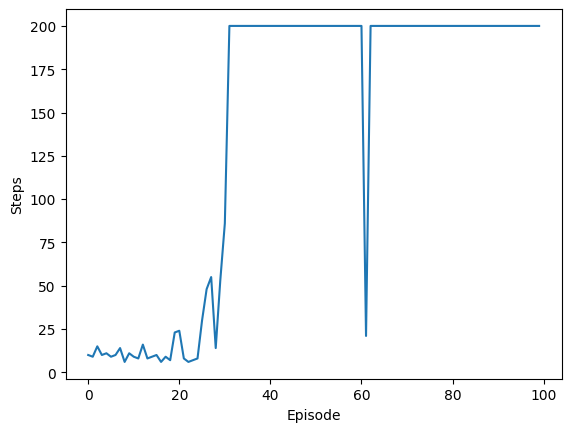

Episode: 1 | Steps: 200 | Average Reward: -0.01 | Average Angle: 4.08 | Average Action (Torque): 0.97 | Starting Angle: -13.97 | Starting Velocity: -0.26 | Percent Safe Action : 77.00 | Percent Safe Action (Old) : 63.00
Episode: 2 | Steps: 200 | Average Reward: -0.01 | Average Angle: 3.00 | Average Action (Torque): 1.08 | Starting Angle: 13.47 | Starting Velocity: -0.05 | Percent Safe Action : 77.00 | Percent Safe Action (Old) : 63.50
Episode: 3 | Steps: 200 | Average Reward: -0.02 | Average Angle: 5.35 | Average Action (Torque): 1.10 | Starting Angle: -11.68 | Starting Velocity: -0.48 | Percent Safe Action : 81.50 | Percent Safe Action (Old) : 70.00
Episode: 4 | Steps: 200 | Average Reward: -0.01 | Average Angle: 2.58 | Average Action (Torque): 1.23 | Starting Angle: -6.66 | Starting Velocity: -0.38 | Percent Safe Action : 87.00 | Percent Safe Action (Old) : 57.00
Episode: 5 | Steps: 200 | Average Reward: -0.00 | Average Angle: 1.92 | Average Action (Torque): 1.30 | Starting Angle: 6.

Average Action (Torque),▁▁▁▁▂▁▁▄▃██▃▃▂▁▂▁▂▅▆▆▆▆█▇▇▆▅▅▅▅▆▇▇▇▆▆▆▆▅
Average Angle,▇▅█▅▇▄▅▆▅▇█▄▄▁▁▁▁▁▂▂▂▂▁▁▁▂▃▃▃▃▂▁▃▂▂▂▁▂▂▂
Average Reward,▃▅▃▅▄▅▃▃▆▁▄▇▇███████████████████████████
Percent Safe Action,▂▇▇▅▃▄▂▂▇▁█▇▇▅▅▆▆▅▇▇▇▇▇▇▇▇▆▆▆▇▇▇▆▇▇▇▇▇▇▇
Percent Safe Action (Only Angle),▂▇▇▅▃▂▂▂▇▁█▇▇▆▅▅▆▆▅▅▅▅▅▅▅▅▆▆▅▅▅▅▆▅▅▅▅▅▅▅
Starting Angle,▇▄█▆▂▃▅▇▂▇▁▇▅▇▃▃▄▄▇▁▇▅▇▂▅▁▆▆▄▅▂▆▅▇▂▄▆█▄▂
Starting Velocity,▃▄▄▆▆▆█▂▅▄▁▃▁▁▆▆▅▅▇█▅▆▃▂▃█▃▆▃▂█▆▁▄▇▅▂▂▅▂
Steps,▁▁▁▁▁▁▁▁▂▁▂▃▄███████████████████████████
Test/Average Action (Torque),▃▄▅▇▄▄▄▆▆▄█▇▇▄▄▄▆▆▆▆▄▆█▁▅▅▅▁▅▄▃▄▃▅▄▆▅▄▆▆
Test/Average Angle,▅▃▇▂▄▂█▂▂▃▃▃▃▃▂▃▂▃▂▁▃▃▁▂▁▁▂▂▂▄▂▂▃▃▄▂▄▂▁▂
Test/Average Reward,▆▇▂▇▇█▁▇█▇▇▆▇▇▇▇█▆███▇██████▇▆██▇▇▆▇▆██▇


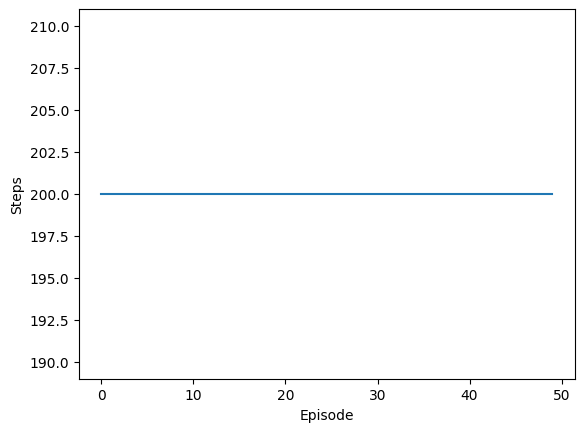

Episode: 1 | Steps: 13 | Average Reward: -0.13 | Average Angle: 12.72 | Average Action (Torque): 0.34 | Starting Angle: -6.20 | Starting Velocity: 0.03 | Percent Safe Action : 30.77 | Percent Safe Action (Old) : 30.77
Episode: 2 | Steps: 6 | Average Reward: -0.21 | Average Angle: 15.39 | Average Action (Torque): 0.59 | Starting Angle: -8.50 | Starting Velocity: -0.45 | Percent Safe Action : 0.00 | Percent Safe Action (Old) : 0.00
Episode: 3 | Steps: 16 | Average Reward: -0.10 | Average Angle: 6.78 | Average Action (Torque): 0.44 | Starting Angle: -2.22 | Starting Velocity: 0.29 | Percent Safe Action : 25.00 | Percent Safe Action (Old) : 6.25
Episode: 4 | Steps: 6 | Average Reward: -0.21 | Average Angle: 18.09 | Average Action (Torque): 0.14 | Starting Angle: -11.51 | Starting Velocity: -0.52 | Percent Safe Action : 66.67 | Percent Safe Action (Old) : 66.67
Episode: 5 | Steps: 7 | Average Reward: -0.20 | Average Angle: 14.47 | Average Action (Torque): 0.37 | Starting Angle: -6.97 | Star

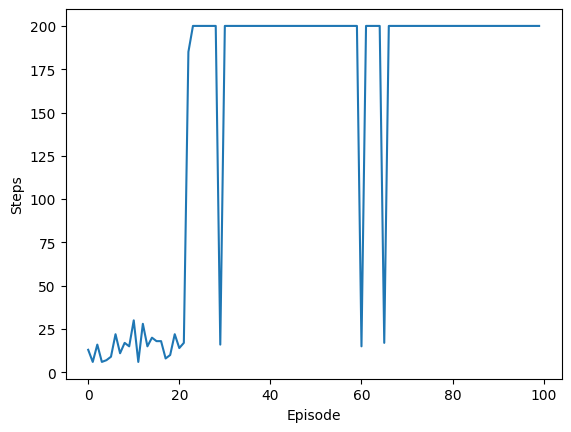

Episode: 1 | Steps: 200 | Average Reward: -0.00 | Average Angle: 1.13 | Average Action (Torque): 1.20 | Starting Angle: 5.72 | Starting Velocity: 0.13 | Percent Safe Action : 92.00 | Percent Safe Action (Old) : 55.50
Episode: 2 | Steps: 200 | Average Reward: -0.01 | Average Angle: 1.90 | Average Action (Torque): 1.17 | Starting Angle: -10.62 | Starting Velocity: -0.18 | Percent Safe Action : 92.00 | Percent Safe Action (Old) : 56.50
Episode: 3 | Steps: 200 | Average Reward: -0.00 | Average Angle: 1.23 | Average Action (Torque): 1.25 | Starting Angle: -7.16 | Starting Velocity: 0.52 | Percent Safe Action : 92.50 | Percent Safe Action (Old) : 54.00
Episode: 4 | Steps: 200 | Average Reward: -0.01 | Average Angle: 1.62 | Average Action (Torque): 1.25 | Starting Angle: 13.43 | Starting Velocity: 0.03 | Percent Safe Action : 93.50 | Percent Safe Action (Old) : 65.00
Episode: 5 | Steps: 200 | Average Reward: -0.01 | Average Angle: 1.57 | Average Action (Torque): 1.17 | Starting Angle: 10.74 |

Average Action (Torque),▂▂▂▁▁▂▃▄▄▂▃▂▂▂▄▃▅▆▄▆▄▄▆▆█▇▇▇▅▆▆▆▆▆▇▆▆▆▆▅
Average Angle,▅▃▆▅▂▃▄▇▆▂▂▂▁▁▁▁▁▁▁▁▁▁▃▂█▂▂▂▂▂▂▂▁▁▁▁▂▁▂▂
Average Reward,▃▅▃▃▆▆▅▁▄▇████████████▇█▂███████████████
Percent Safe Action,▃▂▁▃▂▆▆██▅▆▆▅▆▇▇▇█▇▇▇▇▆▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇▇
Percent Safe Action (Only Angle),▃▁▁▃▅▆▆██▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Starting Angle,▃▄▁▄▄▄▅▁▆▅▇█▄▅▇▄▅▅▇▇▅▅▇▃█▄▇▇▃▃▂▂▁█▂▃▄▅▁▇
Starting Velocity,▄▆▇▁▅▆▅▁▇▂▂▆▁▅▇▂▇▂▂▃▃▁▇▅▇█▃▁▅▁▆▅▅▆▅▂█▇█▃
Steps,▁▁▁▁▂▂▁▁▁▇██████████████▁███████████████
Test/Average Action (Torque),▄▄▅▅▄▆▄▃▅▂▅▃▃▃▄▆▄▇▂▅█▃▄▄▇▇▃▅▆▅▄▅▃▅▁▄▄▆▂▂
Test/Average Angle,▃▇▄▆▅▇▁▇▃▄▅█▅▅▄▂▃▃█▆▄▃▃▄▁▃▆▇▇▄▃▃▄▄▂▄▄▄█▄
Test/Average Reward,▇▄▆▂▆▃█▆▆▇▅▂▄▄▇▇▇▆▂▂▄▇▆▇▆▆▆▄▃▅▇▆▇▆█▇▅▆▁▇


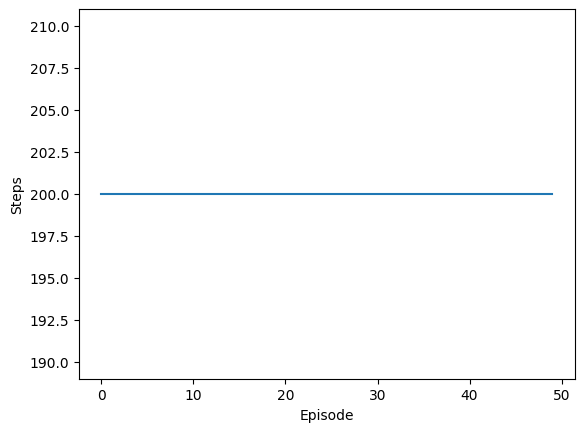

In [ ]:
for _ in range(5):
    config_dict = {'batch_size':128,
                'hidden_size':256,
                'angle_threshold':30,
                'angle_threshold_start':15, #An episode starts only if the initial angle is within this.
                'velocity_threshold_start':0.6,
                'num_episodes':100,
                'num_episodes_test':50,
                'ensure_safe_set':'no safe set',
                'safety_ratio':0.7,
                'wandb_log':True,
                'num_time_steps':200,
                'safe_action_epsilon':0.1,
                'angle_threshold_epsilon':5}

    agent, noise, env, info_train,info_test = run_algo(config_dict)

Episode: 1 | Steps: 200 | Average Reward: -0.01 | Average Angle: 4.86 | Average Action (Torque): 2.00 | Starting Angle: -4.70 | Starting Velocity: 0.40 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 57.50
Episode: 2 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.80 | Average Action (Torque): 2.00 | Starting Angle: 13.94 | Starting Velocity: 0.20 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 95.00
Episode: 3 | Steps: 200 | Average Reward: -0.01 | Average Angle: 4.07 | Average Action (Torque): 2.00 | Starting Angle: -12.17 | Starting Velocity: 0.18 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 6.50
Episode: 4 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.62 | Average Action (Torque): 2.00 | Starting Angle: -14.19 | Starting Velocity: 0.02 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 3.00
Episode: 5 | Steps: 200 | Average Reward: -0.01 | Average Angle: 4.13 | Average Action (Torque): 2.00 | Starting Angle: 10.5

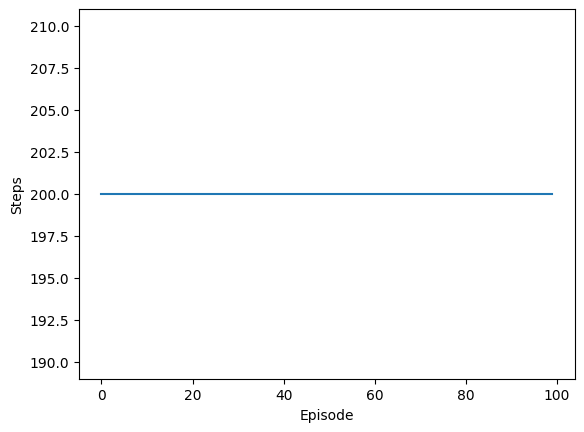

Episode: 1 | Steps: 13 | Average Reward: -0.15 | Average Angle: 13.03 | Average Action (Torque): 1.33 | Starting Angle: -2.33 | Starting Velocity: 0.54 | Percent Safe Action : 84.62 | Percent Safe Action (Old) : 100.00
Episode: 2 | Steps: 9 | Average Reward: -0.18 | Average Angle: 19.22 | Average Action (Torque): 1.82 | Starting Angle: 12.09 | Starting Velocity: -0.41 | Percent Safe Action : 66.67 | Percent Safe Action (Old) : 66.67
Episode: 3 | Steps: 16 | Average Reward: -0.12 | Average Angle: 11.34 | Average Action (Torque): 1.36 | Starting Angle: 0.48 | Starting Velocity: -0.46 | Percent Safe Action : 81.25 | Percent Safe Action (Old) : 75.00
Episode: 4 | Steps: 7 | Average Reward: -0.21 | Average Angle: 20.13 | Average Action (Torque): 1.45 | Starting Angle: 13.58 | Starting Velocity: -0.16 | Percent Safe Action : 71.43 | Percent Safe Action (Old) : 71.43
Episode: 5 | Steps: 12 | Average Reward: -0.15 | Average Angle: 16.48 | Average Action (Torque): 1.49 | Starting Angle: 5.41 | 

Average Action (Torque),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Average Angle,█▁▇▇▇▆▂▆▄▅▆▇▇▄▃▅▅▇▆▆▆▇▆▇▆▇▆▃▄▁▆▆▆▆▇▅█▇▂▆
Average Reward,▆▆▆▂▅▆█▇▅▅▇▅▃▇▅▇▅▆▆▆▆▄▆▃▃▇▇█▄▆▆▇▅▆▆▄▁▃▇▅
Percent Safe Action,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Percent Safe Action (Only Angle),▅▁▇▃▅▅▄▅▄▅▇▄▂▆▇█▃▅▄█▁▁████████▁▁█▁████▁█
Starting Angle,▃▁▃▁▂▃▄▄▁▂▄▇▁▅▁▄▂▆▆▄▆▇▃▁▇▄▄▄▁▁▆▆▂▆▄███▇▃
Starting Velocity,▇▆▃▃▄▄▇▄▅▇▅▆▄▁▇▁▆▇▄▃▄▆█▄▂▅▂▇▆▅▄▅▃▃▂▃▁▅▃▃
Steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/Average Action (Torque),▄█▅▅▄▅▆▇▄▃▄▆▅▅▅▅▅▄▄▇▄▆▄▄▆▅▂▅▃▅▄▅▆▂▄▅▇▆▁▇
Test/Average Angle,▃▇▂▇▁▃▂▇▂▂▄▅▅▂▄▆▂▁▁█▂▄▁▂▃▂▄▃▄▃▅▂▄▂▅▄█▄▁█
Test/Average Reward,▅▄▇▂▇▆▇▄▇▆▅▅▄▇▆▄▇▇▇▃▆▆▇▄▇█▅▅▅▇▃▆▆▅▅▆▁▆▆▂


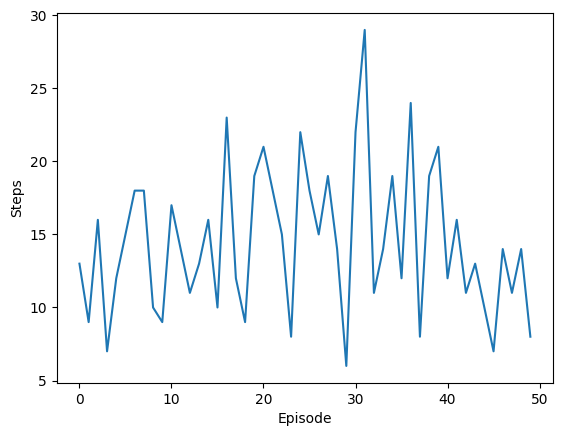

Episode: 1 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.77 | Average Action (Torque): 2.00 | Starting Angle: -7.36 | Starting Velocity: -0.41 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 40.00
Episode: 2 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.96 | Average Action (Torque): 2.00 | Starting Angle: -13.78 | Starting Velocity: -0.42 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 93.50
Episode: 3 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.87 | Average Action (Torque): 2.00 | Starting Angle: 10.69 | Starting Velocity: -0.34 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 100.00
Episode: 4 | Steps: 200 | Average Reward: -0.01 | Average Angle: 3.09 | Average Action (Torque): 2.00 | Starting Angle: -8.72 | Starting Velocity: 0.31 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 18.50
Episode: 5 | Steps: 200 | Average Reward: -0.01 | Average Angle: 4.69 | Average Action (Torque): 2.00 | Starting Angle:

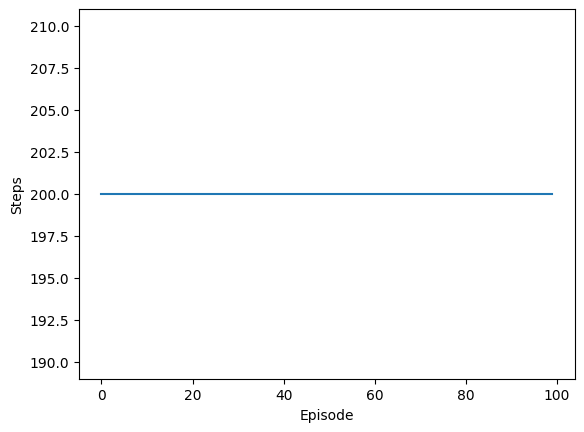

Episode: 1 | Steps: 28 | Average Reward: -0.10 | Average Angle: 11.91 | Average Action (Torque): 1.80 | Starting Angle: -9.38 | Starting Velocity: -0.45 | Percent Safe Action : 85.71 | Percent Safe Action (Old) : 82.14
Episode: 2 | Steps: 8 | Average Reward: -0.20 | Average Angle: 21.37 | Average Action (Torque): 1.89 | Starting Angle: 14.70 | Starting Velocity: -0.19 | Percent Safe Action : 75.00 | Percent Safe Action (Old) : 75.00
Episode: 3 | Steps: 18 | Average Reward: -0.13 | Average Angle: 13.54 | Average Action (Torque): 1.83 | Starting Angle: -1.29 | Starting Velocity: 0.09 | Percent Safe Action : 72.22 | Percent Safe Action (Old) : 83.33
Episode: 4 | Steps: 19 | Average Reward: -0.10 | Average Angle: 11.73 | Average Action (Torque): 1.60 | Starting Angle: -0.09 | Starting Velocity: -0.38 | Percent Safe Action : 68.42 | Percent Safe Action (Old) : 68.42
Episode: 5 | Steps: 10 | Average Reward: -0.17 | Average Angle: 19.95 | Average Action (Torque): 1.73 | Starting Angle: 12.98 

Average Action (Torque),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Average Angle,▇▇▇▁▆█▇▆▆▃▅▆▅▆▆▆█▄▆▆▇▇▆█▅▇▅▇▆▆▆▇▅▆▇▆▇▇▅▅
Average Reward,▅▄▂█▆▁▅▄▆▅▅▆▆▆▆▆▂▆▄▆▆▅▅▂▄▅▄▅▅▅▆▆▄▆▅▅▂▅▆▆
Percent Safe Action,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Percent Safe Action (Only Angle),▄█▂▃▆▃▆▅▅▅▅▄▄▁▇▂▂▂█▁██▁▁▂▁▇██▁█▁▁█▁██▁▁▁
Starting Angle,▃▇█▅▃▁▃▂▅▂▆▃▇▅▄▅▁▇▂▅▄▃▆▁▁▆▇▂▃▆▄▆▂▄▇▂█▆▃▅
Starting Velocity,▂▂▅▄▂▂▇▇▄▇▂▂▄▇▅▂▃▇▁▁▁▃█▃▄▃█▅▂█▁▄▇█▄▇▇▁▆▁
Steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/Average Action (Torque),▆▇▆▄▄▂▇▆▅▇▆▅▇▃▅▅▄▃▃█▇▆▇▇▅▃▇▇▃▃▅▆▆▄▅▃▆▆▁▅
Test/Average Angle,▂█▃▂▂▃▇▂▅▆▇▂▃▂▄█▃▄▃█▃▂▃▂▃█▃▇▁▂▂▆▄▇▇▂▄▂▂▄
Test/Average Reward,█▂▆▇▆▆▄▇▅▅▄█▇▇▅▃▇▅▆▂▆▇▆▇▇▁▆▄██▇▅▆▄▄█▅▇▅▆


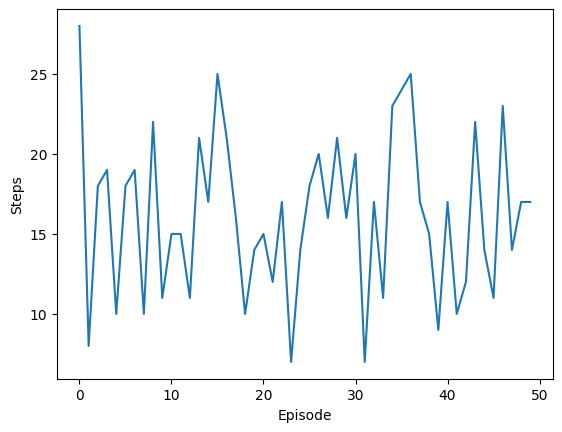

Episode: 1 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.74 | Average Action (Torque): 2.00 | Starting Angle: -13.33 | Starting Velocity: 0.59 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 38.50
Episode: 2 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.52 | Average Action (Torque): 2.00 | Starting Angle: 9.39 | Starting Velocity: -0.58 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 76.50
Episode: 3 | Steps: 200 | Average Reward: -0.02 | Average Angle: 5.06 | Average Action (Torque): 2.00 | Starting Angle: -12.49 | Starting Velocity: -0.19 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 0.00
Episode: 4 | Steps: 200 | Average Reward: -0.01 | Average Angle: 3.09 | Average Action (Torque): 2.00 | Starting Angle: 1.83 | Starting Velocity: -0.57 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 7.50
Episode: 5 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.57 | Average Action (Torque): 2.00 | Starting Angle: 8.2

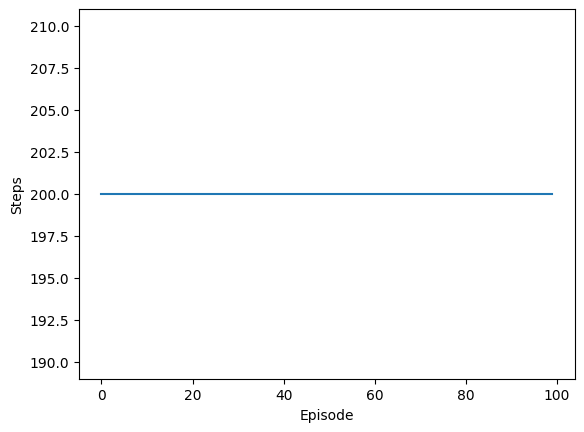

Episode: 1 | Steps: 44 | Average Reward: -0.09 | Average Angle: 14.40 | Average Action (Torque): 1.34 | Starting Angle: -3.06 | Starting Velocity: -0.09 | Percent Safe Action : 93.18 | Percent Safe Action (Old) : 97.73
Episode: 2 | Steps: 15 | Average Reward: -0.14 | Average Angle: 15.22 | Average Action (Torque): 1.47 | Starting Angle: 3.09 | Starting Velocity: -0.17 | Percent Safe Action : 86.67 | Percent Safe Action (Old) : 80.00
Episode: 3 | Steps: 23 | Average Reward: -0.09 | Average Angle: 10.77 | Average Action (Torque): 1.26 | Starting Angle: -10.31 | Starting Velocity: -0.20 | Percent Safe Action : 78.26 | Percent Safe Action (Old) : 82.61
Episode: 4 | Steps: 12 | Average Reward: -0.15 | Average Angle: 16.22 | Average Action (Torque): 1.07 | Starting Angle: 7.55 | Starting Velocity: -0.07 | Percent Safe Action : 75.00 | Percent Safe Action (Old) : 75.00
Episode: 5 | Steps: 23 | Average Reward: -0.10 | Average Angle: 10.71 | Average Action (Torque): 0.91 | Starting Angle: -13.7

Average Action (Torque),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Average Angle,▆█▆▁▇▅▁▅▆▄▆▇▄▆▄▆▅▄▆▇▇▆▆▆▆▆▅▆▅▅▇▄▂▃▅▆▆▇▆▅
Average Reward,▂▃▆▇▂▃█▆▆▇▃▃▆▅▃▆▆▆▅▂▂▁▆▅▅▅▄▅▆▅▄▆▆▅▆▅▄▅▆▅
Percent Safe Action,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Percent Safe Action (Only Angle),▄▁█▁▁▁▁████▁███▅███▁▁▁▁█████▁▁██▁▂█▁▁█▁█
Starting Angle,▁▁▅▂██▄▆▆▄▂▇▅▇█▆▄▄▃▁▁█▅▂▃▃█▃▆▇▂▃▂▂▄▆▇▃▅▂
Starting Velocity,█▃▁▆▆▄▃▂▄▄▇▇▇▆▁▄▄▃▃▇▄▇▄▅▄▆▅▅█▇▁▃▆▅▃▃▆▁▇▃
Steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/Average Action (Torque),▆▇▅▄▇▇▂▁▆▃▄▄▄▂▅▂▂█▃▇▅▅▅▆▅▅▅▆█▅▅▇▅█▅▇▃▄▅▂
Test/Average Angle,▄▄▁▅▅▄▇▃▄▃▂▂▇▆▂▁▆▇▂▆▆▃▂▅▃▃▂▂▄▃▂▂▅▅▂▃▆█▂▄
Test/Average Reward,▇▅▇▅▆▄▃▅▅▅▇▆▅▃▇▇▅▄▇▄▅█▇▅▆▅█▇▆▇▇▇▄▄▇▇▅▁▇▅


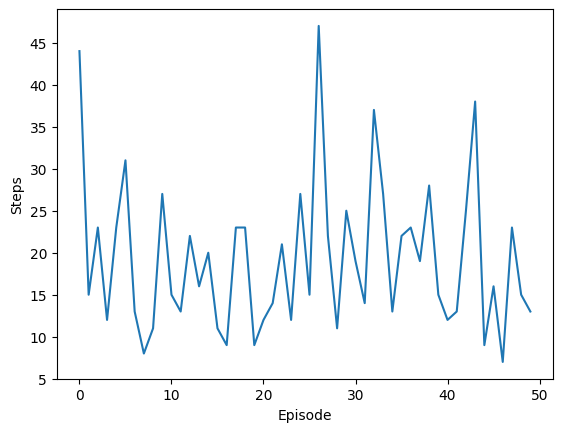

Episode: 1 | Steps: 200 | Average Reward: -0.01 | Average Angle: 3.68 | Average Action (Torque): 2.00 | Starting Angle: 10.30 | Starting Velocity: 0.01 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 51.50
Episode: 2 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.27 | Average Action (Torque): 2.00 | Starting Angle: 10.34 | Starting Velocity: -0.24 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 3.00
Episode: 3 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.86 | Average Action (Torque): 2.00 | Starting Angle: -8.69 | Starting Velocity: -0.13 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 0.00
Episode: 4 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.74 | Average Action (Torque): 2.00 | Starting Angle: -7.24 | Starting Velocity: -0.46 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 0.00
Episode: 5 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.88 | Average Action (Torque): 2.00 | Starting Angle: -14.

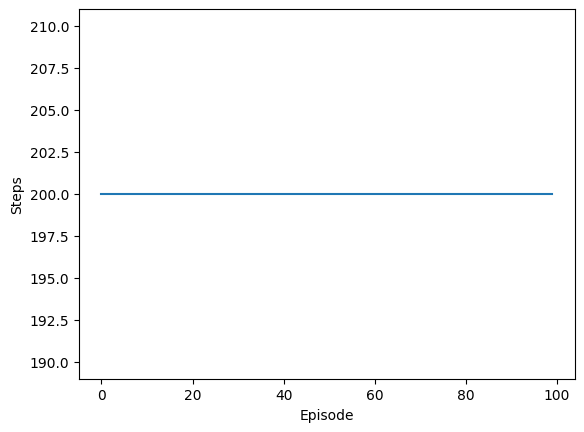

Episode: 1 | Steps: 43 | Average Reward: -0.16 | Average Angle: 22.25 | Average Action (Torque): 1.90 | Starting Angle: 14.27 | Starting Velocity: 0.55 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 100.00
Episode: 2 | Steps: 48 | Average Reward: -0.06 | Average Angle: 11.07 | Average Action (Torque): 1.44 | Starting Angle: 4.13 | Starting Velocity: -0.45 | Percent Safe Action : 81.25 | Percent Safe Action (Old) : 81.25
Episode: 3 | Steps: 41 | Average Reward: -0.06 | Average Angle: 10.48 | Average Action (Torque): 1.33 | Starting Angle: -0.82 | Starting Velocity: -0.32 | Percent Safe Action : 73.17 | Percent Safe Action (Old) : 73.17
Episode: 4 | Steps: 40 | Average Reward: -0.06 | Average Angle: 9.81 | Average Action (Torque): 1.46 | Starting Angle: 5.55 | Starting Velocity: -0.43 | Percent Safe Action : 77.50 | Percent Safe Action (Old) : 80.00
Episode: 5 | Steps: 48 | Average Reward: -0.08 | Average Angle: 13.93 | Average Action (Torque): 1.44 | Starting Angle: -3.46 

Average Action (Torque),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Average Angle,▁▅▃▅▅▅▄▄▅▃▄█▅▄▅▄▄▅▅▂▅▄▅▅▅▄▅▆▂▅▅▅▅▂▄▆▅▅▅▅
Average Reward,█▇▇▇▆▆▇▆▇▇▆▁▇▆▇▇▆▅▇█▇▇▇▇▇▅▇▆█▇▇▆▇█▇▅▇▇▇▆
Percent Safe Action,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Percent Safe Action (Only Angle),▅▁▇█▁█▁▂▇▇▃▄▆▄▄▆▄▆▅▆▄▄▄▇▄▄▄▆▆▇▄▄▆▄▇▃▃▃▃▇
Starting Angle,▇▃▂▇▂▇▂▇▆██▁▅▁▆▃▂▁▆▅▆▅▆▃▆▁▆▂▃▃▆█▄▄▇█▃▃▃▁
Starting Velocity,▄▄▃▆▆▇▅█▆▄▃▁█▃█▇█▃▃▁█▇▄▂▂▆▃▂▆▄▃▆▄▂▄▇█▂▃▅
Steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/Average Action (Torque),█▅▄▅▅▅▆▁▇▅▅▅▃▆▃▇▄▄▇▆▅▆▅▆▃▆▅▅▇▄▅▆▆▅▅▆▆▆▅▅
Test/Average Angle,█▃▂▂▂▃▃▇▄▂▆▅▅▂▂▇▁▁▃▅▃▃▅▆▂▃▂▃▃▆▂▃▃▂▃▃▃▄▂▄
Test/Average Reward,▁▇▇▇▇▆▆▁▆█▄▅▅▇▇▃▇█▆▅▇▇▅▃▇▆▇▇▆▄▇▇▇▇▇▆▇▆█▆


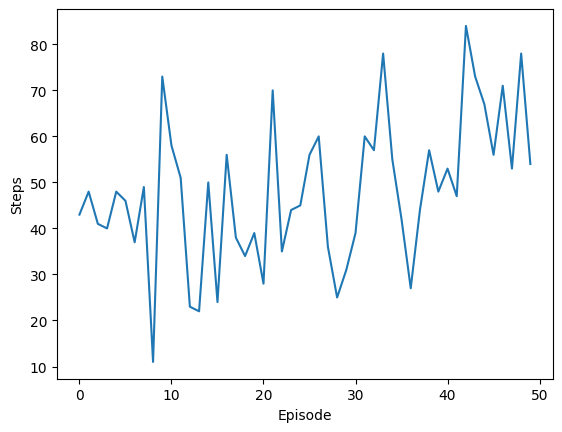

Episode: 1 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.61 | Average Action (Torque): 2.00 | Starting Angle: 10.20 | Starting Velocity: 0.07 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 30.00
Episode: 2 | Steps: 200 | Average Reward: -0.02 | Average Angle: 4.45 | Average Action (Torque): 2.00 | Starting Angle: -12.11 | Starting Velocity: -0.15 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 4.50
Episode: 3 | Steps: 200 | Average Reward: -0.01 | Average Angle: 4.76 | Average Action (Torque): 2.00 | Starting Angle: 5.76 | Starting Velocity: -0.36 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 0.00
Episode: 4 | Steps: 200 | Average Reward: -0.01 | Average Angle: 4.79 | Average Action (Torque): 2.00 | Starting Angle: -2.99 | Starting Velocity: 0.38 | Percent Safe Action : 100.00 | Percent Safe Action (Old) : 100.00
Episode: 5 | Steps: 200 | Average Reward: -0.01 | Average Angle: 4.77 | Average Action (Torque): 2.00 | Starting Angle: 5.6

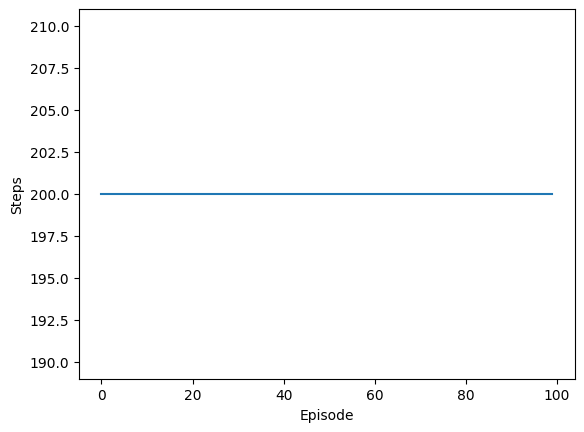

Episode: 1 | Steps: 5 | Average Reward: -0.25 | Average Angle: 18.53 | Average Action (Torque): 2.00 | Starting Angle: 13.55 | Starting Velocity: -0.11 | Percent Safe Action : 0.00 | Percent Safe Action (Old) : 0.00
Episode: 2 | Steps: 12 | Average Reward: -0.29 | Average Angle: 11.32 | Average Action (Torque): 1.73 | Starting Angle: -13.85 | Starting Velocity: 0.26 | Percent Safe Action : 41.67 | Percent Safe Action (Old) : 58.33
Episode: 3 | Steps: 14 | Average Reward: -0.17 | Average Angle: 9.25 | Average Action (Torque): 1.93 | Starting Angle: -10.19 | Starting Velocity: -0.39 | Percent Safe Action : 57.14 | Percent Safe Action (Old) : 71.43
Episode: 4 | Steps: 5 | Average Reward: -0.26 | Average Angle: 15.46 | Average Action (Torque): 1.80 | Starting Angle: 8.87 | Starting Velocity: 0.34 | Percent Safe Action : 0.00 | Percent Safe Action (Old) : 0.00
Episode: 5 | Steps: 6 | Average Reward: -0.31 | Average Angle: 11.11 | Average Action (Torque): 1.92 | Starting Angle: 1.56 | Starti

Average Action (Torque),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Average Angle,▄▅▂▄▄▂▄▄▄▅▅▄▄▃▃█▃▅▃▅▄▄▄▅▁▄▃▃▄▅▃▄▄▅▄▅▄▅▅▆
Average Reward,▇▇▇▇▇█▇█▇▇▇▇▇█▇▁▇▇█▇▇▇▇▇▇▇▇▇▇▇██▇▆▇▆▇▄▅▄
Percent Safe Action,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Percent Safe Action (Only Angle),▃▁█▄▃▅▅▂▇▁▁▆▁▁███▁█▁█▁▁▁▁██▁▁▁▁▁███▁█▁▁█
Starting Angle,▇▆▂▃▆▅▅▄▅▃▃▃▆▅▃▁▂▆▄▇▃▅▇▆▂▄▂▇▅▆▅▅▃▂▃▇▂▁█▁
Starting Velocity,▅▂▅▆▃▃▁███▃▃▂▂█▁▂▆▇▆▃▇▆▄▃▄▃▄▄▃▇▃▅▄▂▃▃▆▆▂
Steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/Average Action (Torque),█▆▇▆▇▆▇▅██▃▇▇█▁▆█▆▂▇▄▆▇▇█▃██▇▄██▇█▅▆▆▆▇█
Test/Average Angle,▇▃▂▅▆▅▂▄▄▆▃▆▂▂█▅▃▂▂▄▆▃▂▂▂▂▂▂▃▃▃▆▂▆▃▃▁▁▃▅
Test/Average Reward,▅▃█▄▇▇▆▅▄▅▅▆▅▆▇▄▅█▇▅▃▅▂▆▄█▃▄▁▆▄▅▃▃▆▆█▇▄▅


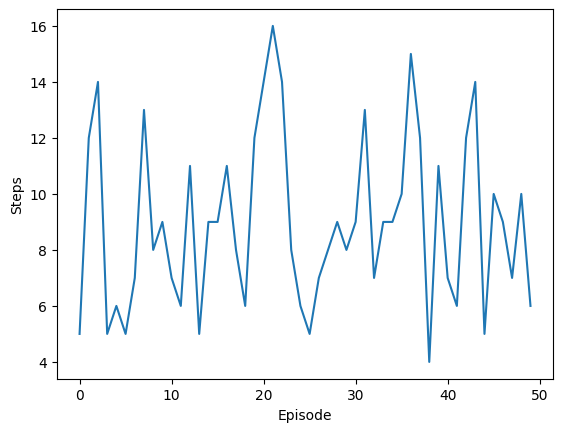

In [ ]:
for _ in range(5):
    config_dict = {'batch_size':128,
                'hidden_size':256,
                'angle_threshold':30,
                'angle_threshold_start':15, #An episode starts only if the initial angle is within this.
                'velocity_threshold_start':0.6,
                'num_episodes':100,
                'num_episodes_test':50,
                'ensure_safe_set':'safe',
                'safety_ratio':0.7,
                'wandb_log':True,
                'num_time_steps':200,
                'safe_action_epsilon':0.1,
                'angle_threshold_epsilon':5}

    agent, noise, env, info_train,info_test = run_algo(config_dict)

In [ ]:
for _ in range(5):
    config_dict = {'batch_size':128,
                'hidden_size':256,
                'angle_threshold':30,
                'angle_threshold_start':15, #An episode starts only if the initial angle is within this.
                'velocity_threshold_start':0.6,
                'num_episodes':100,
                'num_episodes_test':50,
                'ensure_safe_set':'partially_safe',
                'safety_ratio':0.7,
                'wandb_log':True,
                'num_time_steps':200,
                'safe_action_epsilon':0.1,
                'angle_threshold_epsilon':5}

    agent, noise, env, info_train,info_test = run_algo(config_dict)

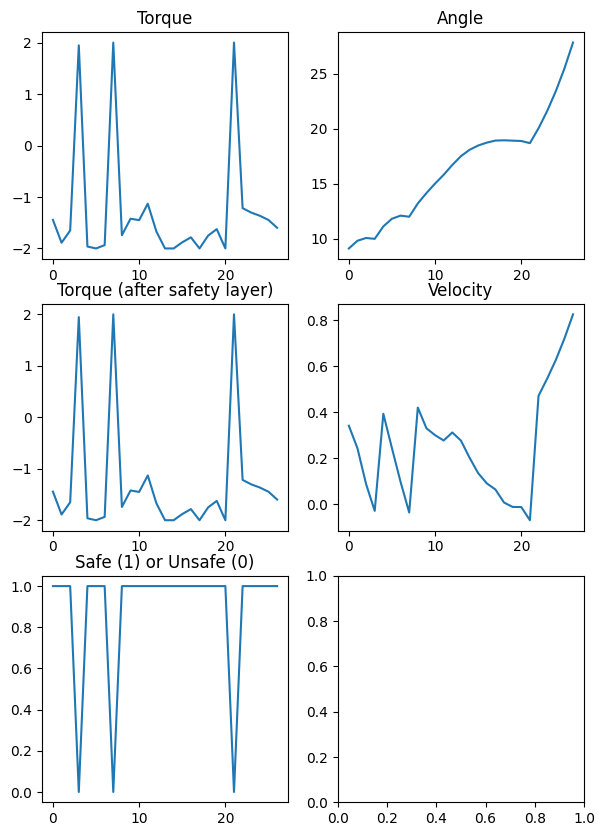

In [ ]:
episode = 37
info = info_test

window = [0,200]
fig,ax = plt.subplots(3,2,figsize=(7,10))
ax[0,0].plot(info['action_trajectories'][episode][window[0]:window[1]])
ax[0,0].set_title('Torque')

ax[1,0].plot(info['action_trajectories_after_safety_layer'][episode][window[0]:window[1]])
ax[1,0].set_title('Torque (after safety layer)')

ax[2,0].plot(info['safe_action_flag_trajectories'][episode][window[0]:window[1]])
ax[2,0].set_title('Safe (1) or Unsafe (0)')

ax[0,1].plot(info['angle_trajectories'][episode][window[0]:window[1]])
ax[0,1].set_title('Angle')

ax[1,1].plot(info['velocity_trajectories'][episode][window[0]:window[1]])
ax[1,1].set_title('Velocity')
plt.show()

(array([6., 4., 3., 4., 5., 4., 9., 8., 2., 5.]),
 array([-91.88905524, -72.97329713, -54.05753902, -35.1417809 ,
        -16.22602279,   2.68973533,  21.60549344,  40.52125155,
         59.43700967,  78.35276778,  97.26852589]),
 <BarContainer object of 10 artists>)

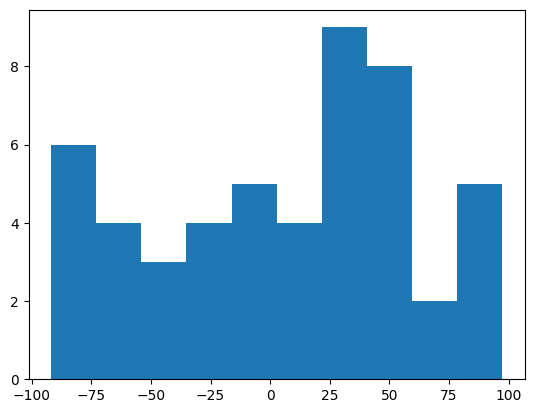

In [ ]:
plt.hist(info['starting_angles'])

## Full State Space

In [ ]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

class DDPGagent:

    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000,angle_threshold = 20):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        self.env = env

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        assert self.env.action_space.high[0]==2

        return self.env.action_space.high[0]*action # Coz the output of the policy network is between -1,1 (added on 4/10/2023)

    def is_safe(self,state,action):

        assert len(state)==3

        angle = np.arctan2(state[1],state[0])*180/np.pi
        angle_threshold = 20
        safety = 1
        # if abs(angle)<angle_threshold:
        #     if action*angle>0: #if both action and the angle have same sign
        #         safety = 0
        if abs(angle)>angle_threshold:
            if action*angle>0: #if both action and the angle have same sign
                safety = 0


        return safety

    def get_safe_action(self,state,action,epsilon=0.1):

        assert len(state)==3

        safety = self.is_safe(state,action)
        if safety:
            return action
        else:

            resolution = 100
            action_range = self.env.action_space.high[0]

            probab = np.random.uniform(0,1)
            if probab<epsilon:
                if action[0]<=0:
                    action = np.random.uniform(0,action_range)

                else:
                    action = np.random.uniform(0,-action_range)

                return np.array([action])

            if action[0]<=0:
                safe_action_space = torch.linspace(0,action_range,resolution).unsqueeze(1)
                #We need the safe action set in the direction opposite to angle deviation

            else:
                safe_action_space = torch.linspace(0,-action_range,resolution).unsqueeze(1)

            state_tensor = Variable(torch.from_numpy(state).float().unsqueeze(0))
            state_concat = torch.cat([state_tensor] * resolution, dim=0) #Stacked Tensor with same state value to pass into critic

            Qvals = self.critic.forward(state_concat, safe_action_space)
            action_index = torch.argmax(Qvals)

            #action is a (1,1) shaped ndarray below
            action = safe_action_space[action_index].detach().numpy() #finding the action with highest Q value
            return action

    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Critic loss
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()

        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        # Update the noise state according to the Ornstein-Uhlenbeck process
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)


def run_algo(config_dict):
    batch_size = config_dict['batch_size']
    hidden_size = config_dict['hidden_size']
    num_episodes = config_dict['num_episodes']
    angle_threshold = config_dict['angle_threshold']
    ensure_safe_set = config_dict['ensure_safe_set']
    safety_ratio = config_dict['safety_ratio']


    if config_dict['wandb_log']:
        wandb.init(
            # set the wandb project where this run will be logged
            project="ddpg",

            # track hyperparameters and run metadata
            config=config_dict
        )

    env = gym.make("Pendulum-v1",render_mode = 'rgb_array')
    agent = DDPGagent(env,hidden_size=hidden_size,angle_threshold = angle_threshold)
    noise = OUNoise(env.action_space)

    rewards = []
    avg_rewards = []

    for episode in range(num_episodes):
        state,_ = env.reset()
        noise.reset()
        episode_reward = 0
        within_threshold_count = 0
        action_within_threshold = 0
        safe_action_count_within_threshold = 0
        angle_sum = 0

        for step in range(200):

            angle = np.arctan2(state[1],state[0])*180/np.pi
            angle_sum += abs(angle)

            action = agent.get_action(state) # This is scalar
            action = noise.get_action(action, step) # This is a numpy array


            if abs(angle)<angle_threshold:
                within_threshold_count +=1
                assert len(action)==1
                action_within_threshold += abs(action[0])

                if agent.is_safe(state,action):
                    safe_action_count_within_threshold+=1 #Stores the number of times an action generated is safe

            if ensure_safe_set=='safe':
                action = agent.get_safe_action(state,action)

            elif ensure_safe_set == 'partially_safe':
                if np.random.uniform(0,1) < safety_ratio:
                    action = agent.get_safe_action(state,action)




            #     # Trying to Debug how the safety layer is affecting things
            #     if abs(angle)<angle_threshold:
            #         if not agent.is_safe(state, initial_action):
            #             print("Initial Action: {}, After Safety Layer {}, State: {}".format(initial_action,action,state))

            # # Debugging
            # else:
            #     if abs(angle)<angle_threshold:
            #         if not agent.is_safe(state, action):
            #             print("Action: {}, State: {}".format(action,state))

            new_state, reward, done, truncated,_ = env.step(action)
            agent.memory.push(state, action, reward, new_state, done)

            if len(agent.memory) > batch_size:
                agent.update(batch_size)

            state = new_state
            episode_reward += reward

            if done or truncated:
                if within_threshold_count==0:
                    avg_action_within_threshold=0
                    safe_action_percent = np.nan
                else:
                    avg_action_within_threshold = action_within_threshold/within_threshold_count
                    safe_action_percent = round(100*safe_action_count_within_threshold/within_threshold_count)
                if config_dict['wandb_log']:
                    wandb.log({"Reward": np.round(episode_reward, decimals=2),
                               "Steps within Threshold":within_threshold_count,
                               "Avg Torque within Threshold":avg_action_within_threshold,
                               "Safe Action Count":safe_action_percent,
                               "Avg_Angle":angle_sum/200})

                sys.stdout.write("Episode: {}, Step: {}, Reward: {:.2f}, Average_Reward: {:.2f}, Within_threshold_count: {}, Avg_Torque: {:.2f}, Safe Action Percent: {} ,Avg Angle: {:.2f}\n".format(episode,
                                                                                                                                                                            step,
                                                                                                                                                                            np.round(episode_reward, decimals=2),
                                                                                                                                                                            np.mean(rewards[-10:]),
                                                                                                                                                                            within_threshold_count,
                                                                                                                                                                            avg_action_within_threshold,
                                                                                                                                                                            safe_action_percent,
                                                                                                                                                                            angle_sum/200))
                break

        rewards.append(episode_reward)
        avg_rewards.append(np.mean(rewards[-10:]))

    if config_dict['wandb_log']:
        wandb.finish()

    plt.plot(rewards)
    plt.plot(avg_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
    return agent, noise, env

In [ ]:
config_dict = {'batch_size':128,
               'hidden_size':256,
               'angle_threshold':60,
               'num_episodes':50,
               'ensure_safe_set':'safe',
               'safety_ratio':None,
               'wandb_log':True}
run_algo(config_dict)

In [ ]:
config_dict = {'batch_size':128,
               'hidden_size':256,
               'angle_threshold':60,
               'num_episodes':50,
               'ensure_safe_set':'partially_safe',
               'safety_ratio':0.7,
               'wandb_log':True}
run_algo(config_dict)

## Testing

In [ ]:
def get_safe_action(self,state,action,epsilon=0.1):

    # assert len(state)==3

    # safety = self.is_safe(state,action)
    # if safety:
    #     return action
    # else:

    angle = np.arctan2(state[1],state[0])*180/np.pi
    action_range = self.env.action_space.high[0]

    # if abs(state[2])>0:
    #     action = -action_range
    # else:
    #     action = action_range

    if abs(angle)<self.angle_threshold_epsilon:
        if state[2]>0:
            action = -action_range
        elif state[2]<0:
            action = action_range
        else:
            action = 0

    else:
        if angle>0:
            action = -action_range
        else:
            action = action_range

    return np.array([action])

In [ ]:
while True:
    state,_ = env.reset()
    if agent.is_safe_state2(state):
        break

noise.reset()
episode_reward = 0

video_frames = []
agent.angle_theshold_epsilon = 2
for step in range(200):
    action = agent.get_action(state)
    action = noise.get_action(action, step)

    angle = np.arctan2(state[1],state[0])*180/np.pi
    if step%5==0:
        pass
    else:
        action = agent.get_safe_action(state,action)

    new_state, reward, done, _ ,_= env.step(action)
    agent.memory.push(state, action, reward, new_state, done)
    frame = env.render()
    video_frames.append(frame)

    # if len(agent.memory) > batch_size:
    #     agent.update(batch_size)

    state = new_state
    episode_reward += reward

    print(angle,agent.angle_threshold,action)
    if abs(angle)>agent.angle_threshold:

        done = True
        print("Step:",step)
        break
    # if done:
    #     sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
    #     break


# env.render(mode='rgb_array')

-4.449260784313999 20 [0.31223171]
-4.370394297515155 20 [-2.]
-5.314695271026097 20 [2.]
-5.598574581517929 20 [2.]
-5.232629694374748 20 [-2.]
-5.9220728311772435 20 [-0.07701083]
-6.866291415531323 20 [2.]
-7.2079430273440614 20 [2.]
-6.95974377130273 20 [-2.]
-7.831330124022894 20 [2.]
-8.136240867629665 20 [-0.35555659]
-8.898025526139527 20 [2.]
-9.132709972247518 20 [2.]
-8.848985621672481 20 [-2.]
-9.755217682070711 20 [2.]
-10.166068074798964 20 [-0.2900999]
-11.080811404676677 20 [2.]
-11.549062707189718 20 [2.]
-11.588039181688396 20 [2.]
-11.199174314124768 20 [2.]
-10.368173372339642 20 [-0.09661286]
-9.96537662641648 20 [-2.]
-10.793836737830361 20 [2.]
-11.16523851923356 20 [2.]
-11.09325600934444 20 [2.]
-10.575239094765042 20 [-0.12625495]
-10.505800830341753 20 [2.]
-9.968689268163937 20 [-2.]
-10.66295579918093 20 [2.]
-10.895344447954152 20 [2.]
-10.674411733966334 20 [0.76815538]
-10.521368539007504 20 [2.]
-9.901225782184428 20 [-2.]
-10.509970660830046 20 [2.]
-1

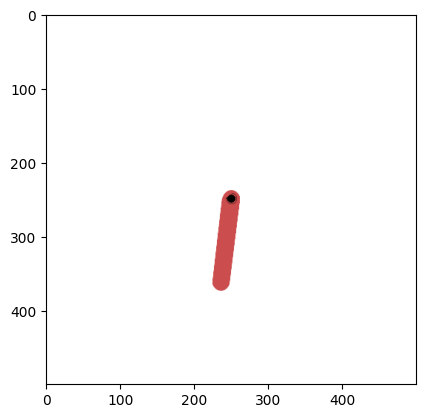

In [ ]:
plt.imshow(frame)

In [ ]:
frame_width = 500
frame_height = 500
width, height = (frame_width, frame_height)

output_video_filename = 'output_video.mp4'
fps = 30

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(output_video_filename, fourcc, fps, (width, height))

for frame_rgb in video_frames:
    frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
    out.write(frame_bgr)

out.release()

## Simple Pendulum, safe sets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def f1(theta,theta0):
    theta = np.array(theta)
    if (abs(theta)>theta0).any():
        raise ValueError('Theta Value is outside safe range')
    else:
        return np.sqrt((6/(m*l**2))*(Tm*(theta0-theta)+0.5*m*g*l*(np.cos(theta0)-np.cos(theta))))

def f2(theta,theta0):
    theta = np.array(theta)

    if (abs(theta)>theta0).any():
        raise ValueError('Theta Value is outside safe range')
    else:
        return -np.sqrt((6/(m*l**2))*(Tm*(theta0+theta)+0.5*m*g*l*(np.cos(theta0)-np.cos(theta))))


def plot_safe_set(theta0,ax,color):
    theta_axis = np.linspace(-theta0,theta0,1000)

    boundary_1 = f1(theta_axis,theta0)
    boundary_2 = f2(theta_axis,theta0)

    theta_axis = theta_axis*180/np.pi

    ax.grid(True)
    ax.plot(theta_axis,boundary_1,color=color)
    ax.plot(theta_axis,boundary_2,color=color)
    ax.plot([theta_axis[0],theta_axis[0]],[boundary_1[0],boundary_2[0]],color=color)
    ax.plot([theta_axis[-1],theta_axis[-1]],[boundary_1[-1],boundary_2[-1]],color=color)
    ax.set_xlim([-35,35])
    ax.set_ylim([-4,4])
    ax.set_ylabel(r'$\dot{\theta}$ (rad/s)')
    ax.set_xlabel(r'$\theta$ (in degrees)')
    ax.set_title(r'$\theta_{0}$ = ' + str(int(round(theta0*180/np.pi,0))))

    return ax

In [ ]:
theta0 = 20*np.pi/180
Tm = 2
m = 1
l = 1
g = 9.8
theta = 0
omega = 0

h1 = -Tm*(theta0-theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))
h2 = -Tm*(theta0+theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))

def is_safe_state2(theta,omega,theta0):
    if abs(theta)>theta0:
        return False

    if omega>=0:
        h = -Tm*(theta0-theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))
    else:
        h = -Tm*(theta0+theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))

    if h<=0:
        return True
    else:
        return False

def is_safe_state(theta,omega,theta0):
    if abs(theta)>theta0:
        return False
    else:
        if omega - f1(theta,theta0)<0 and omega-f2(theta,theta0)>0:
            return True
        else:
            return False

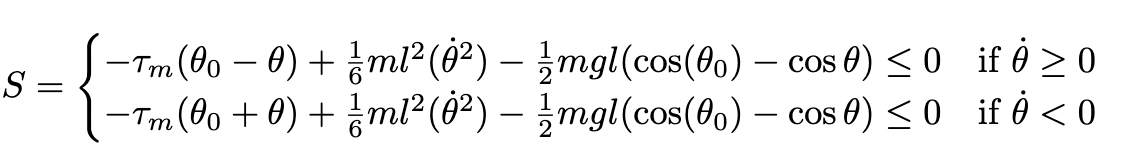

In [ ]:
omega = -1.7
theta = 30*np.pi/180
theta0 = 20*np.pi/180

print(is_safe_state2(theta,omega,theta0))
print(is_safe_state(theta,omega,theta0))

False
False


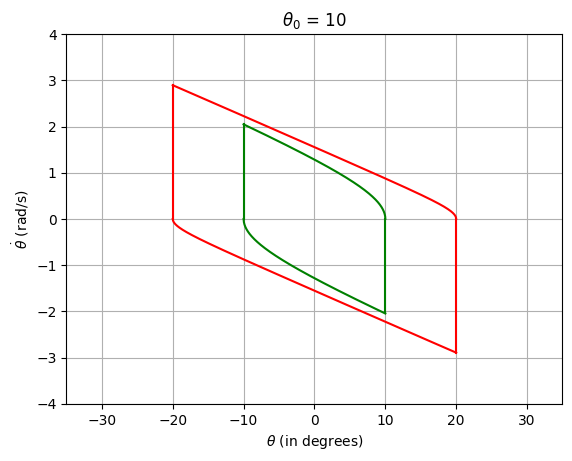

In [ ]:
Tm = 2
theta0 = 20*np.pi/180
m = 1
l = 1
g = 9.81

fig,ax = plt.subplots()

ax = plot_safe_set(theta0,ax,color='red')

theta0 = 10*np.pi/180
ax = plot_safe_set(theta0,ax,color='green')

In [ ]:

plt.show()

In [ ]:
def get_angle(state):
    return (np.arctan2(state[1],state[0])*180/np.pi)

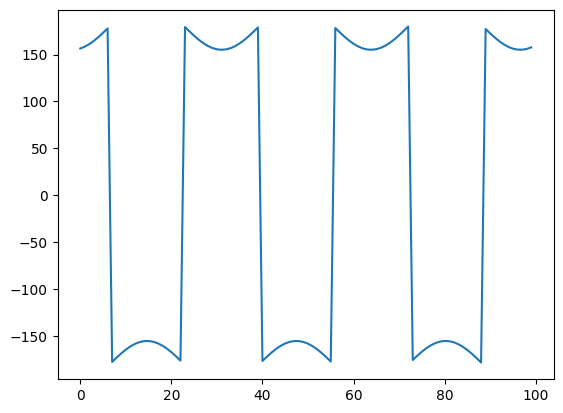

In [ ]:
env = gym.make("Pendulum-v1",render_mode = 'rgb_array')
state = env.reset()
done=False
action = [0]
angles = []
velocities = []
video_frames = []
for i in range(100):
    new_state, reward, done, _ ,_= env.step(action)
    angle = get_angle(new_state)
    velocity = new_state[2]

    angles.append(angle)
    velocities.append(velocity)
    frame = env.render()
    video_frames.append(frame)

plt.plot(angles)

## Distrubution of the Initial State

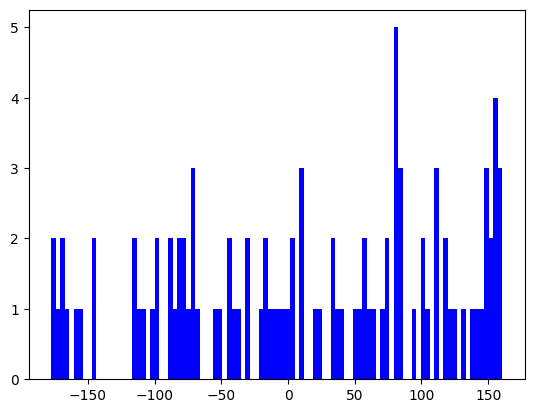

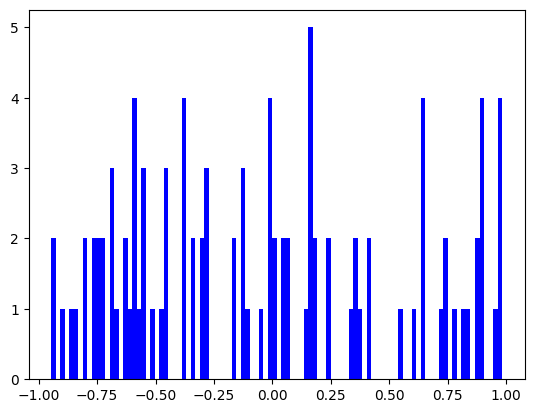

In [ ]:
env = gym.make("Pendulum-v1",render_mode = 'rgb_array')
angles = []
velocities = []
for i in range(100):
    state,_ = env.reset()
    angle = np.arctan2(state[1],state[0])*180/np.pi
    angles.append(angle)
    velocities.append(state[2])

plt.hist(angles, bins=100, color='b')
plt.figure()
plt.hist(velocities, bins=100, color='b')


plt.show()

## Rough

In [ ]:
   #### TESTING PHASE #####

    rewards = []

    starting_angles = []
    average_action_list = []
    average_angle_list = []
    average_reward_list = []
    steps_list = []
    average_safe_action_list = []
    action_trajectories = []
    safety_violations_list = []

    episode = 0
    while episode < num_episodes//2:
        action_trajectory = []
        state,_ = env.reset()

        if abs(get_angle(state))>angle_threshold_start:
            # Ensuring that the episode starts in a safe state
            continue
        else:
            episode += 1
            starting_angle = (np.arctan2(state[1],state[0])*180/np.pi)


            starting_angles.append(starting_angle) # Data Collection
            assert abs(starting_angle)<angle_threshold

            # noise.reset()
            episode_reward = 0
            within_threshold_count = 0
            action_within_threshold = 0
            safe_action_count_within_threshold = 0
            angle_sum = 0
            action_sum = 0
            step = 0
            num_safe_actions = 0
            safety_violations = 0
            while True:
                step+=1
                angle = np.arctan2(state[1],state[0])*180/np.pi
                angle_sum += abs(angle)

                action = agent.get_action(state) # This is scalar
                action = np.array([action])
                # action = noise.get_action(action, step) # This is a numpy array

                if action*angle<=0: #Must be less than or equal to i.e complement of action*angle>0 for unsafe
                    num_safe_actions+=1

                # if ensure_safe_set=='safe':
                #     action = agent.get_safe_action(state,action,safe_action_epsilon)
                #     assert agent.is_safe(state,action)==1

                # elif ensure_safe_set == 'partially_safe':
                #     if np.random.uniform(0,1) < safety_ratio:
                #         action = agent.get_safe_action(state,action,safe_action_epsilon)

                #logging
                action_sum += abs(action[0])


                new_state, reward, done, truncated,_ = env.step(action)

                if abs(get_angle(new_state))>angle_threshold:
                    # If the state goes outside the safe set, the episode is terminated
                    safety_violations += 1
                    # done = True

                # agent.memory.push(state, action, reward, new_state, done)

                # if len(agent.memory) > batch_size:
                #     agent.update(batch_size)

                state = new_state
                episode_reward += reward

                if done or truncated:


                    # Logging
                    average_action = action_sum/step
                    average_angle = angle_sum/step
                    average_reward = episode_reward/step
                    average_num_safe_action = num_safe_actions/step

                    steps_list.append(step)
                    average_angle_list.append(average_angle)
                    average_action_list.append(average_action)
                    average_reward_list.append(average_reward)
                    average_safe_action_list.append(average_num_safe_action*100)
                    safety_violations_list.append(safety_violations)

                    if config_dict['wandb_log']:

                        wandb.log({'Test/Steps':step,
                                   'Test/Average Reward':average_reward,
                                   'Test/Average Angle':average_angle,
                                   'Test/Average Action (Torque)':average_action,
                                   'Test/Starting Angle':starting_angle,
                                   'Test/Percent Safe Action':average_num_safe_action*100})

                    print("TESTING PHASE || Episode: {} | Steps: {} | Average Reward: {:.2f} | Average Angle: {:.2f} | Average Action (Torque): {:.2f} | Starting Angle: {:.2f} | Percent Safe Action : {:.2f}".format(episode,step,
                                                                                                                                                               average_reward,
                                                                                                                                                               average_angle,
                                                                                                                                                               average_action,
                                                                                                                                                               starting_angle,
                                                                                                                                                               average_num_safe_action*100))

                    break







In [ ]:
pip install highway-env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
import highway_env
import matplotlib.pyplot as plt
import gymnasium as gym

highway_env.register_highway_envs()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment exit-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment highway-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment highway-fast-v0 already in registry.
  logger.warn(f"Overriding environment {n

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_type to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_type` for environment variables or `env.get_wrapper_attr('action_type')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_type to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_type` for environment variables or `env.get_wrapper_attr('action_type')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_type to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_type` for environment variables or `env.get_wr

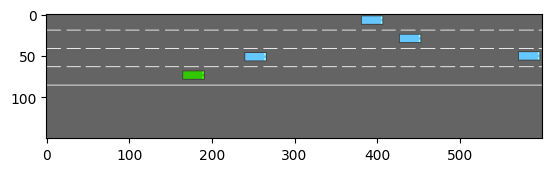

In [ ]:
env = gym.make('highway-v0', render_mode='rgb_array')
env.reset()
for _ in range(3):
    action = env.action_type.actions_indexes["IDLE"]
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
plt.show()

-1.6473887
[-0.31833062 -0.94797975  0.70562494]


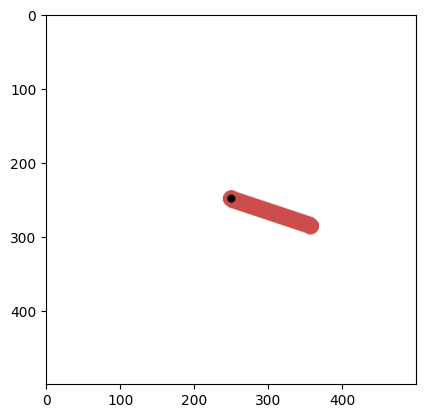

In [ ]:
env = (gym.make("Pendulum-v1",render_mode='rgb_array'))

state,_ = env.reset()

frame = env.render()
plt.imshow(frame)

state_tensor = Variable(torch.from_numpy(state).float().unsqueeze(0))

print(agent.get_action(state))
print(state)

In [ ]:
action

-1.6473887

In [ ]:
action = agent.get_action(state)
action

-1.6473887

In [ ]:



action = agent.get_action(state) # Scalar
action = np.array([action])


resolution = 10
action_range = env.action_space.high[0]

if action[0]<=0:
    safe_action_space = torch.linspace(0,action_range,10).unsqueeze(1) #We need the safe action set in the direction opposite to angle deviation

else:
    safe_action_space = torch.linspace(0,-action_range,10).unsqueeze(1)

state_tensor = Variable(torch.from_numpy(state).float().unsqueeze(0))
state_concat = torch.cat([state_tensor] * resolution, dim=0) #Stacked Tensor with same state value to pass into critic

Qvals = agent.critic.forward(state_concat, safe_action_space)

action_index = torch.argmax(Qvals)

#action is a (1,1) shaped ndarray below
action = safe_action_space[action_index].detach().numpy() #finding the action with highest Q value

array([2.], dtype=float32)

In [ ]:
safe_action_space[1]

tensor([0.2222])

In [ ]:
torch.argmax(Qvals)

tensor(9)